In [1]:
#load rpy2 magic
%load_ext rpy2.ipython

# to switch off warning messages
import warnings
warnings.filterwarnings("ignore")

# make default cell width 85% of available screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# show multiple tables in python shells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# load R libraries & functions
%R options(warn=-1)
%R library(RColorBrewer)
%R library(ggplot2)
%R library(gplots)
%R library(gridExtra)
%R library(ggrepel)
    
# load python modules
import glob
import re
import sys
import os
import rpy2.robjects as robjects
import CGAT.Database as DB
import sqlite3
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

db = "./csvdb"

# **MEME-ChIP Report**
***
## **DREME** 
- Searches for **short**, ungapped motifs, relatively enriched vs background (flanking regions)
- TOMTOM compares discovered motifs against database(s) of known motifs

In [2]:
%%R

# R functions
theme_notebook <- function(base_size=18, base_family="helvetica") {
                  (theme_set(theme_minimal(base_size=18))
                  + theme(plot.title = element_text(face="bold", size=20, hjust=0.5),
                             text = element_text(),
                             axis.title = element_text(face="bold",size = rel(1)),
                             axis.title.y = element_text(angle=90,vjust=2, size=20),
                             axis.title.x = element_text(vjust=-0.2, size=20),
                             axis.text = element_text(size=20),
                             axis.line = element_line(colour="black"),
                             axis.ticks = element_line(),
                             legend.key = element_rect(colour = NA),
                             legend.key.size= unit(0.5, "cm"),
                             legend.margin = unit(0.5, "cm"),
                             legend.text = element_text(size=14),
                             legend.title = element_text(size=16),
                             strip.text = element_text(size=18)
                             ))
}

# Set ggplot theme
theme_set(theme_notebook(base_size=18))
Palette <- c("#E69F00", "#0072B2", "#D55E00", "#009E73", "#56B4E9",  "#999999", "#F0E442")

In [3]:
def motif_lookup(db):
    
    with open("./pipeline.ini", "r") as o:
        for line in o:
            a = re.findall("^motif_db=.*", line)
            if len(a) > 0:
                dbs = a[0].split(",")

    df1 = {}
    df2 = {}
    df3 = {}
    
    transfac = [x for x in dbs if "transfac" in x]
    jaspar = [x for x in dbs if "JASPAR" in x]
    uniprobe = [x for x in dbs if "uniprobe" in x]
    hocomoco = [x for x in dbs if "HOCOMOCO" in x]
    chen = [x for x in dbs if "chen" in x]

    n = 0
    for i in [transfac, jaspar, uniprobe]:
        n = n + 1
        if n == 1:
            db_name = "transfac"
        if n == 2:
            db_name = "jaspar"
        if n == 3:
            db_name = "uniprobe"
        meme = ''.join(i).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(" ")
                    motif_id = motif[1]
                    motif_name = motif[2]
                    df1[motif_name] = motif_id

        if n == 1:
            dfs = pd.DataFrame.from_dict(df1, orient="index")
            dfs.columns = ["motif_id"]
            dfs["motif_name"] = dfs.index.values
            dfs.reset_index(inplace=True, drop=True)
            dfs["database"] = db_name
        else:
            dfs1 = pd.DataFrame.from_dict(df1, orient="index")
            dfs1.columns = ["motif_id"]
            dfs1["motif_name"] = dfs1.index.values
            dfs1.reset_index(inplace=True, drop=True)
            dfs1["database"] = db_name
            
            dfs = dfs.append(dfs1)

    if len(hocomoco) > 0:
        meme = ''.join(hocomoco).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(".")
                    motif[0].split(".")
                    motif_name = str(motif[0]).replace("MOTIF ", "")
                    motif_suffix = '.'.join(motif[1:3])
                    motif_id = '.'.join([motif_name, motif_suffix])
                    df2[motif_name] = motif_id

        df2 = pd.DataFrame.from_dict(df2, orient="index")
        df2.columns = ["motif_id"]
        df2["motif_name"] = df2.index.values
        df2.reset_index(inplace=True, drop=True)
        df2["database"] = "hocomoco"
    
    if len(chen) > 0:
        meme = ''.join(chen).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(" ")
                    motif_id = motif[1]
                    motif_name = motif[1]
                    df3[motif_name] = motif_id
                
        df3 = pd.DataFrame.from_dict(df3, orient="index")
        df3.columns = ["motif_id"]
        df3["motif_name"] = df3.index.values
        df3.reset_index(inplace=True, drop=True)
        df3["database"] = "chen"
    
    # merge all dfs
    df = dfs.append([df2, df3])
    
    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("motif_table", connect, if_exists="replace", index=False)

    return df

df = motif_lookup(db)

In [4]:
def dreme_summary(db, conditions="", widths="", no_peaks="", samples=""):

    beds = glob.glob("data.dir/*_meme.bed")

    names = []
    for bed in beds:
        name = os.path.basename(bed).split("_")[0]
        names.append(name)

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

    df = []
    n = 0
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    table = '_'.join([name, c, str(peaks), str(width)]) + "_Dreme_tomtom"


                    # get corresponding meme e_values for discovered motifs from meme.txt
                    meme_out = "meme.chip.dir/" + '_'.join([name, c]) + "." + '.'.join([str(peaks), str(width)]) + "/dreme_out/dreme.txt"
                    if os.path.exists(meme_out):
                        with open(meme_out, "r") as open_meme:
                            l = 0
                            for line in open_meme:
                                motif = re.findall("^#.*", line)
                                if len(motif) > 0:
                                    l = l + 1
                                    if l > 6:
                                        motif =  [ x for x in motif if "Stopping" not in x]
                                        motif =  [ x for x in motif if "Running" not in x]
                                        motif =  [ x for x in motif if "Word" not in x]
                                        if len(motif) > 0:
                                            motif = [x for x in ''.join(motif).split() if x not in ["BEST", "#"]]
                                            motif.append(table.replace("_Dreme_tomtom", ""))
                                            df.append(motif)

    df = pd.DataFrame(df, columns = ["motif", "motif_rc", "pos", "neg", "p_value", "dreme_evalue", "run"])
    df.drop("p_value", inplace=True, axis=1)
#     df = df.drop_duplicates()

    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("dreme_motifs", connect, if_exists="replace", index=False)

    return df

dreme = dreme_summary(db, conditions=["increase", "decrease"])

In [5]:
def dremechip_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    if len(samples)==0:
        names = []
        for bed in beds:
            name = os.path.basename(bed).split("_")[0]
            names.append(name)
    else:
        names = samples

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

    # get existing tables in db
    dbhandle = sqlite3.connect(db)
    cc = dbhandle.cursor()
    cc.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tabs = cc.fetchall()
    tables = pd.DataFrame(tabs, columns=["tables"])

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    table = '_'.join([name, c, str(peaks), str(width)]) + "_Dreme_tomtom"

                    if tables["tables"].str.contains(table).any():

                        statement = '''select a.query_id, a.query_consensus, a.target_id, 
                                    b.motif_name, b.database, a.e_value as tomtom_evalue, a.orientation
                                    from %(table)s a, motif_table b where a.target_id = b.motif_id 
                                    order by e_value asc''' % locals()

                        df = DB.fetch_DataFrame(statement, db)
                        df = df.drop_duplicates()
                        df["run"] = str(table).rstrip("_Dreme_tomtom")
                        df["DESeq2_comparison"] = df["run"].apply(lambda x: x.split("_")[0])
                        df["condition"] = df["run"].apply(lambda x: x.split("_")[1])
                        df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[2])
                        df["window"] = df["run"].apply(lambda x: x.split("_")[3])

                        dfs.append(df)


    c = 0
    for df in dfs:
        c = c + 1
        if c == 1:
            motifs = df
        else:
            motifs = motifs.append(df)
        motifs.head()
            
    motifs["motif_name"] = motifs["motif_name"].apply(lambda x: x.replace("_MOUSE", ""))
    
    return motifs

motifs = dremechip_summary(db, conditions=["increase", "decrease"])

In [6]:
def analyse_dreme(motifs, dreme):

    # reformat dfs for merge
    motifs.rename(columns={"query_id":"motif"}, inplace=True)

    # merge dfs
    dreme_chip = pd.merge(dreme, motifs, how="inner", on=["run", "motif"])
    dreme_chip.drop_duplicates(inplace=True)

    dreme_chip["dreme_evalue"] = dreme_chip["dreme_evalue"].apply(lambda x: float(x)) # correct type
    dreme_chip["settings"] = dreme_chip["no_peaks"] + "_" + dreme_chip["window"] # make column for plot annotations

    # subset on sig motifs & sig matches
    dreme_chip = dreme_chip[(dreme_chip.tomtom_evalue < 0.05) & (dreme_chip.dreme_evalue < 0.05)].sort_values(["dreme_evalue", "tomtom_evalue"], ascending=True)
    dreme_chip = dreme_chip[dreme_chip["dreme_evalue"] != 0]
    dreme_chip = dreme_chip[dreme_chip["tomtom_evalue"] != 0]
    
    return dreme_chip

dreme_chip = analyse_dreme(motifs, dreme)

## Effect of MEME-ChIP Settings on DREME & TOMTOM

In [7]:
# make new df for plots
dreme_evalue = dreme_chip.copy(deep=True)
dreme_evalue.index.name = None
dreme_evalue.reset_index(inplace=True, drop=True)
dreme_evalue = dreme_evalue.drop_duplicates(["target_id", "motif_name", "run", "motif"], keep="first")

In [8]:
%%R -i dreme_evalue

a <- ggplot(dreme_evalue, aes(y=-log10(tomtom_evalue), x=-log10(dreme_evalue), shape=factor(query_id), alpha=condition, colour=database)) +
        geom_jitter(size=3) + 
        scale_alpha_discrete(range=c(0.4, 1)) +
        facet_grid(settings ~ DESeq2_comparison) +
        theme(legend.position="bottom", legend.direction="horizontal")
        
b <- ggplot(dreme_evalue, aes(y=-log10(dreme_evalue), x=window, fill=no_peaks)) + 
        geom_boxplot(aes(alpha=dreme_evalue), position="dodge")  +
        scale_fill_manual(values=Palette) + 
        labs(title="Dreme motif discovery", x="Peak width")
        
c <- ggplot(dreme_evalue, aes(y=-log10(tomtom_evalue), x=window, fill=no_peaks)) + 
        geom_boxplot(aes(alpha=dreme_evalue), position="dodge")  +
        scale_fill_manual(values=Palette) + 
        labs(title="Tomtom motif comparison", x="Peak width")

In [9]:
dreme_motif_no = dreme_evalue.groupby(["run", "window", "no_peaks"]).agg({"motif_name":"count"})
dreme_motif_no.reset_index(inplace=True)

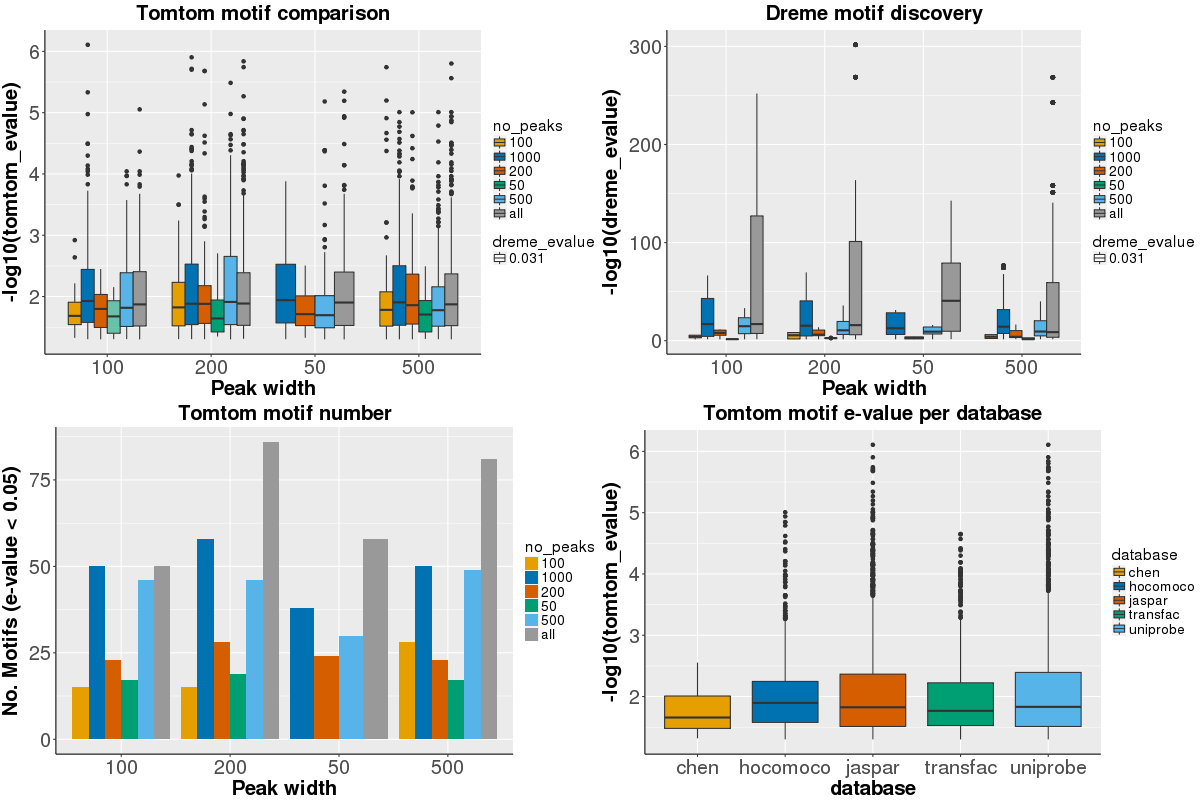

In [10]:
%%R -i dreme_motif_no,dreme_chip -w 1200 -h 800

# meme_motif_no <- meme_motif_no[order(meme_motif_no$motif_name, descending=TRUE), ]
d <- ggplot(dreme_motif_no, aes(y=motif_name, x=window, fill=no_peaks)) + 
        geom_bar(stat="identity", position="dodge")  +
        scale_fill_manual(values=Palette) + 
        labs(title="Tomtom motif number", x="Peak width", y="No. Motifs (e-value < 0.05)")# +
#         scale_x_discrete(limits=unique(meme_motif_no$window))
        
e <- ggplot(dreme_chip, aes(y=-log10(tomtom_evalue), x=database, fill=database)) + 
        geom_boxplot() +
        scale_fill_manual(values=Palette) +
        labs(title="Tomtom motif e-value per database")
        
grid.arrange(c, b, d, e, ncol=2, nrow=2)

## DREME-ChIP Summary
* For simplicity results from all MEME-ChIP runs are aggregated
    * TOMTOM & DREME e-values are averaged across runs
    * No. motif occurances between runs and databases is counted
    * All DREME motifs have an e-value < 0.05
* This is to provide an overview of the data, do not use for downstream analysis

In [11]:
# aggregate data
dreme_summary = dreme_chip.groupby(["target_id", "motif_name", "motif", "DESeq2_comparison", "condition"]).agg({"tomtom_evalue":"mean", "dreme_evalue":"mean", "run":"count", "database":"count"})
dreme_summary.reset_index(inplace=True)

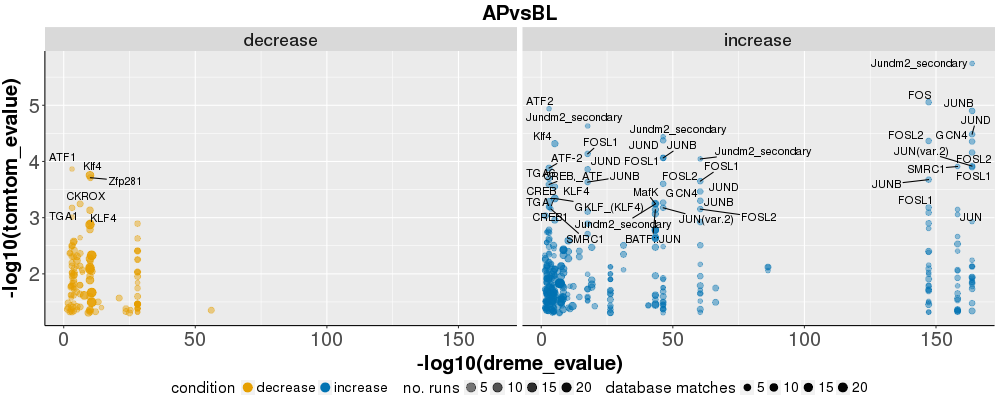

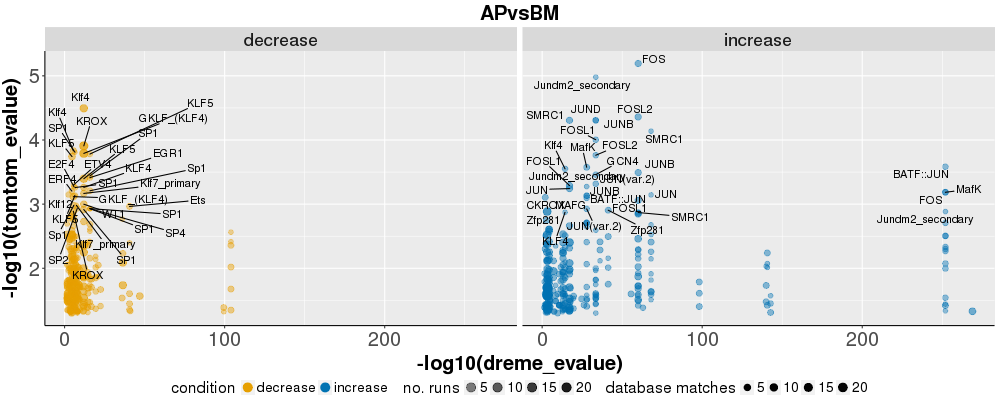

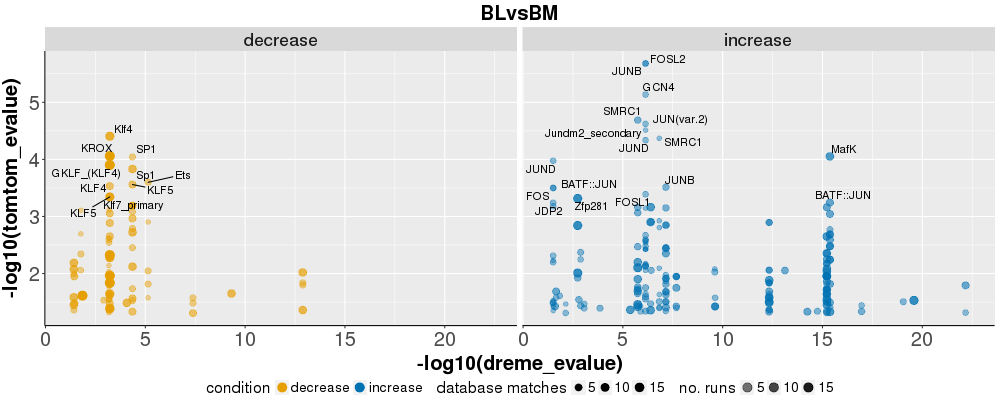

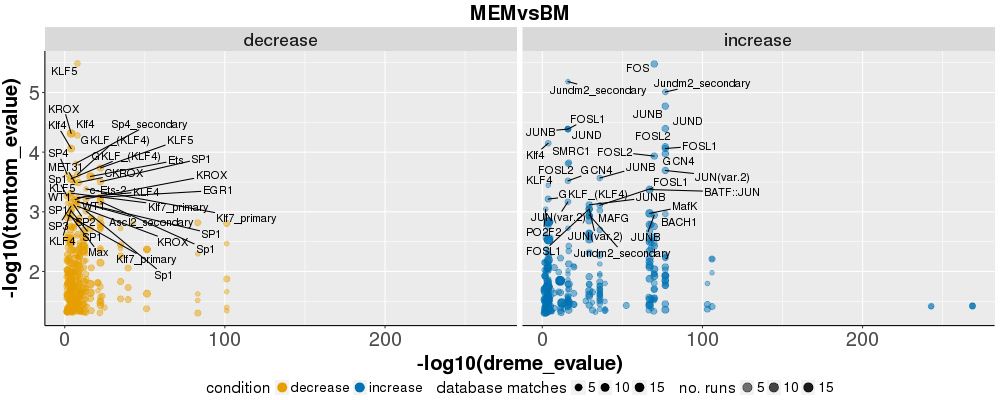

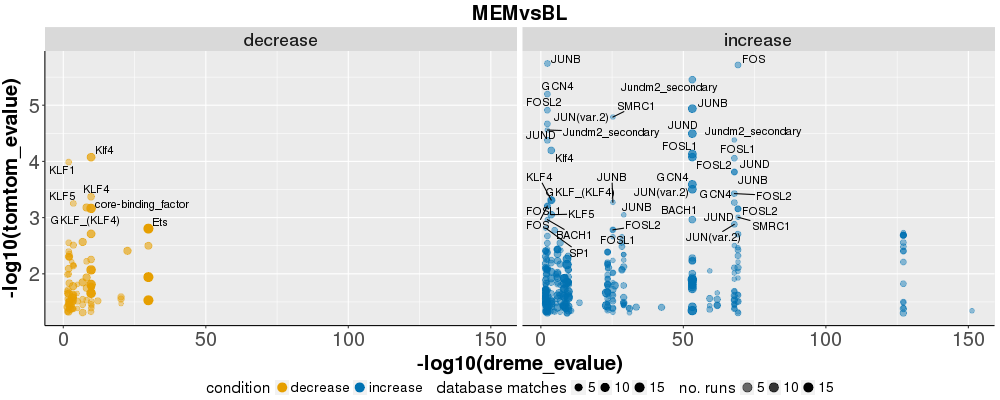

In [12]:
%%R -i dreme_summary -w 1000 -h 400

for (comp in unique(dreme_summary$DESeq2_comparison)){

    df <- subset(dreme_summary, DESeq2_comparison == comp)

    p <- ggplot(df, aes(y=-log10(tomtom_evalue), x=-log10(dreme_evalue), alpha=run, colour=condition)) +
            geom_point(aes(size=database), position=position_jitterdodge()) + 
            scale_size(range=c(2,4), name="database matches") +
            scale_alpha(range=c(0.4,1), name="no. runs") +
            scale_shape_manual(values=c(16, 17, 15), name="meme motif") +
            geom_text_repel(
                data=df[-log10(df$tomtom_evalue) > 
                          quantile(-log10(df$tomtom_evalue), 0.9, na.rm=T), ], 
                aes(label=motif_name), colour="black", alpha=1, position=position_jitterdodge()) +
            facet_wrap(~ condition) +
            theme(legend.position="bottom", legend.direction="horizontal") +
            scale_colour_manual(values=Palette) +
            guides(color=guide_legend(override.aes=list(size=4)), alpha=guide_legend(override.aes=list(size=4))) +
            labs(title=comp)
    
    grid.arrange(p, ncol=1, nrow=1)
}

## DREME & TOMTOM Results for Each Run & Sample
* Mutliple database hits for the same motif discovered by DREME are merged (TOMTOM e-values are averaged)

In [13]:
# make new df for plot
dreme_graph = dreme_chip.copy(deep=True)

# count occurnaces of the same motif matching a TF in many databases
# average tomtom_evalue in these instances
dreme_graph = dreme_graph.groupby(["target_id", "motif_name", "motif","orientation", "run", "DESeq2_comparison", "condition", "settings"]).agg({"database":"count", "dreme_evalue":"min", "tomtom_evalue":"mean"})
dreme_graph.reset_index(inplace=True)

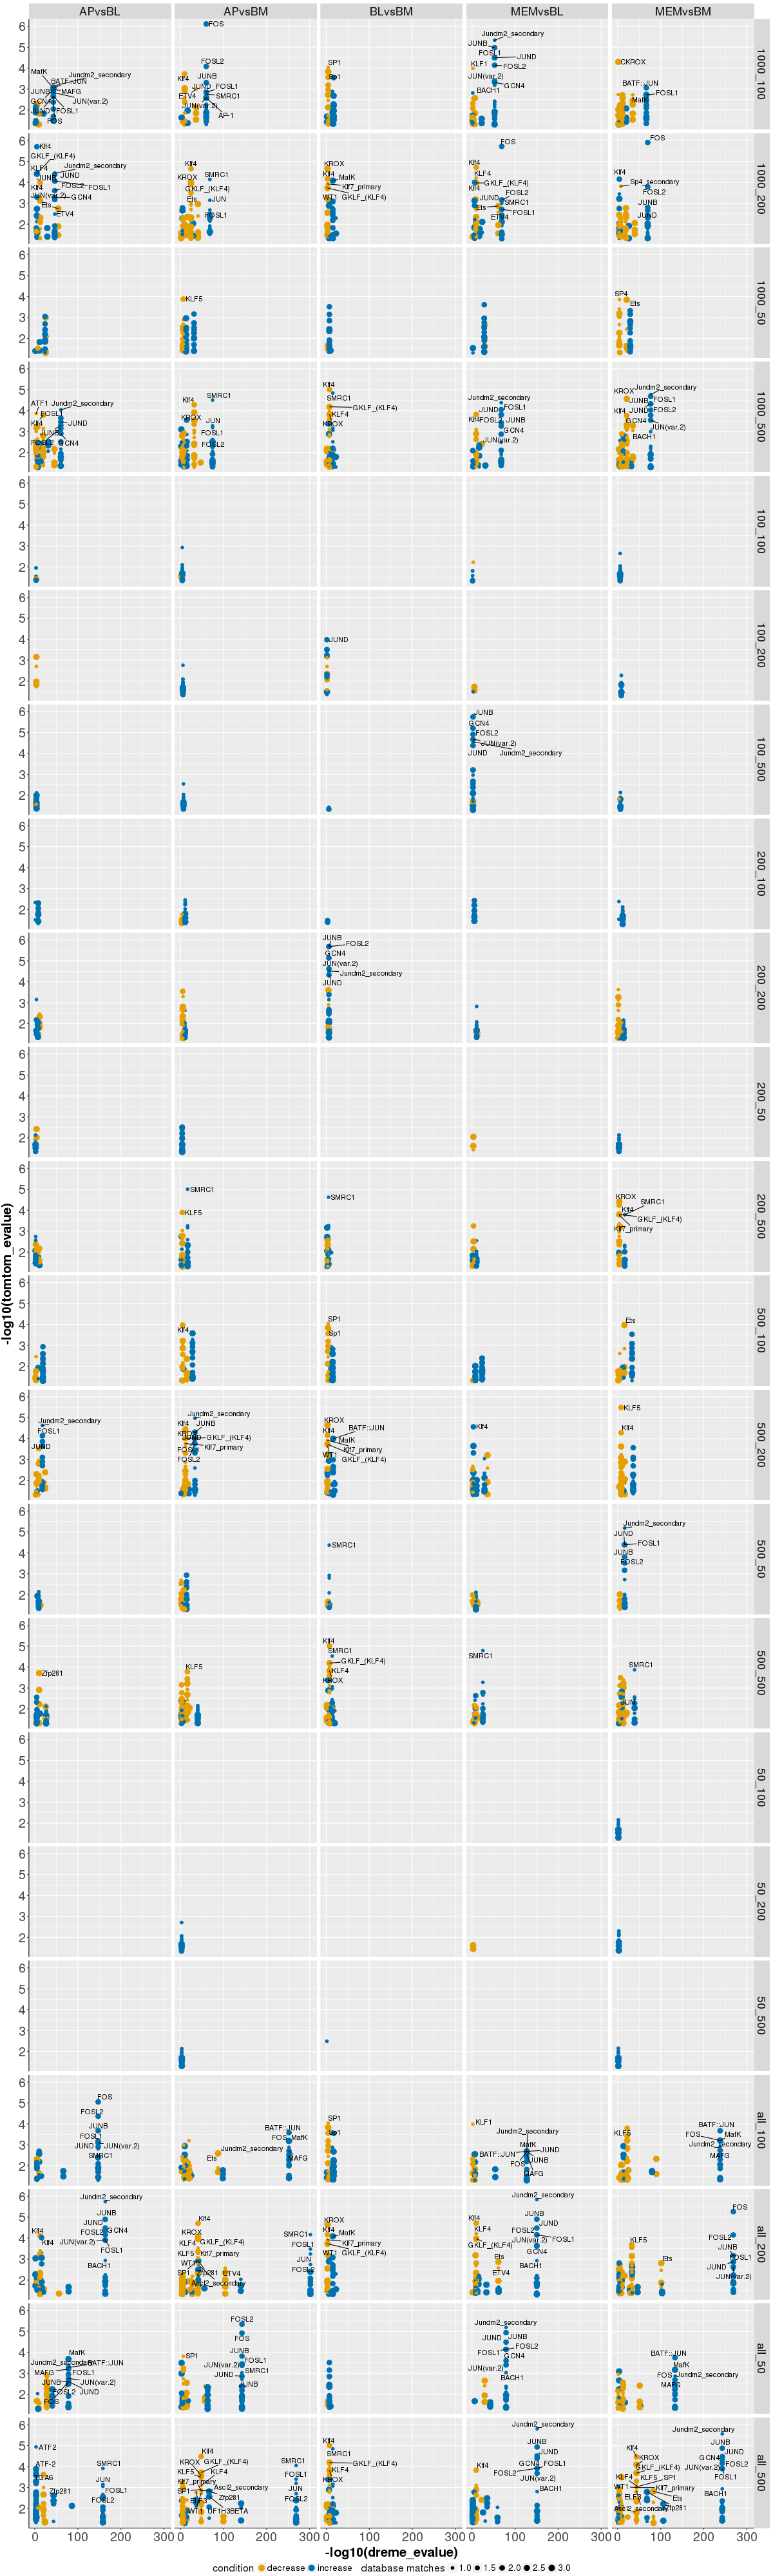

In [14]:
%%R -i dreme_graph -w 1200 -h 4000

ggplot(dreme_graph, aes(y=-log10(tomtom_evalue), x=-log10(dreme_evalue), colour=condition)) +
    geom_jitter(aes(size=database)) + 
    scale_size(range=c(2,4), name="database matches") +
    geom_text_repel(data=dreme_graph[-log10(dreme_graph$"dreme_evalue") > 
                                   quantile(-log10(dreme_graph$"dreme_evalue"), 0.8, na.rm=T) &
                                   -log10(dreme_graph$"tomtom_evalue") > 
                                   quantile(-log10(dreme_graph$"tomtom_evalue"), 0.8, na.rm=T) |#, ], 
                                   -log10(dreme_graph$"dreme_evalue") > quantile(-log10(dreme_graph$"dreme_evalue"), 0.95, na.rm=T)  &
                                   -log10(dreme_graph$"tomtom_evalue") > 
                                   quantile(-log10(dreme_graph$"tomtom_evalue"), 0.9, na.rm=T) |
                                   -log10(dreme_graph$"tomtom_evalue") > quantile(-log10(dreme_graph$"tomtom_evalue"), 0.95, na.rm=T), ], 
                    aes(y=-log10(tomtom_evalue), x=-log10(dreme_evalue), label=motif_name), colour="black") +
    facet_grid(settings ~ DESeq2_comparison) +
    theme(legend.position="bottom", legend.direction="horizontal") +
    scale_colour_manual(values=Palette) +
    guides(color=guide_legend(override.aes=list(size=4))) +
    guides(shape=guide_legend(override.aes=list(size=4)))

### Top Database Matches per DREME Motif 
* All discovered motifs have e-value < 0.05
* Multiple database matches for DREME motifs are grouped by TF name & TOMTOM e-values averaged

In [15]:
# make extra cols for annotation
dreme_graph["width"] = dreme_graph["settings"].apply(lambda x: "width_" + x.split("_")[1])
dreme_graph["peaks"] = dreme_graph["settings"].apply(lambda x: "npeaks_" + x.split("_")[0])

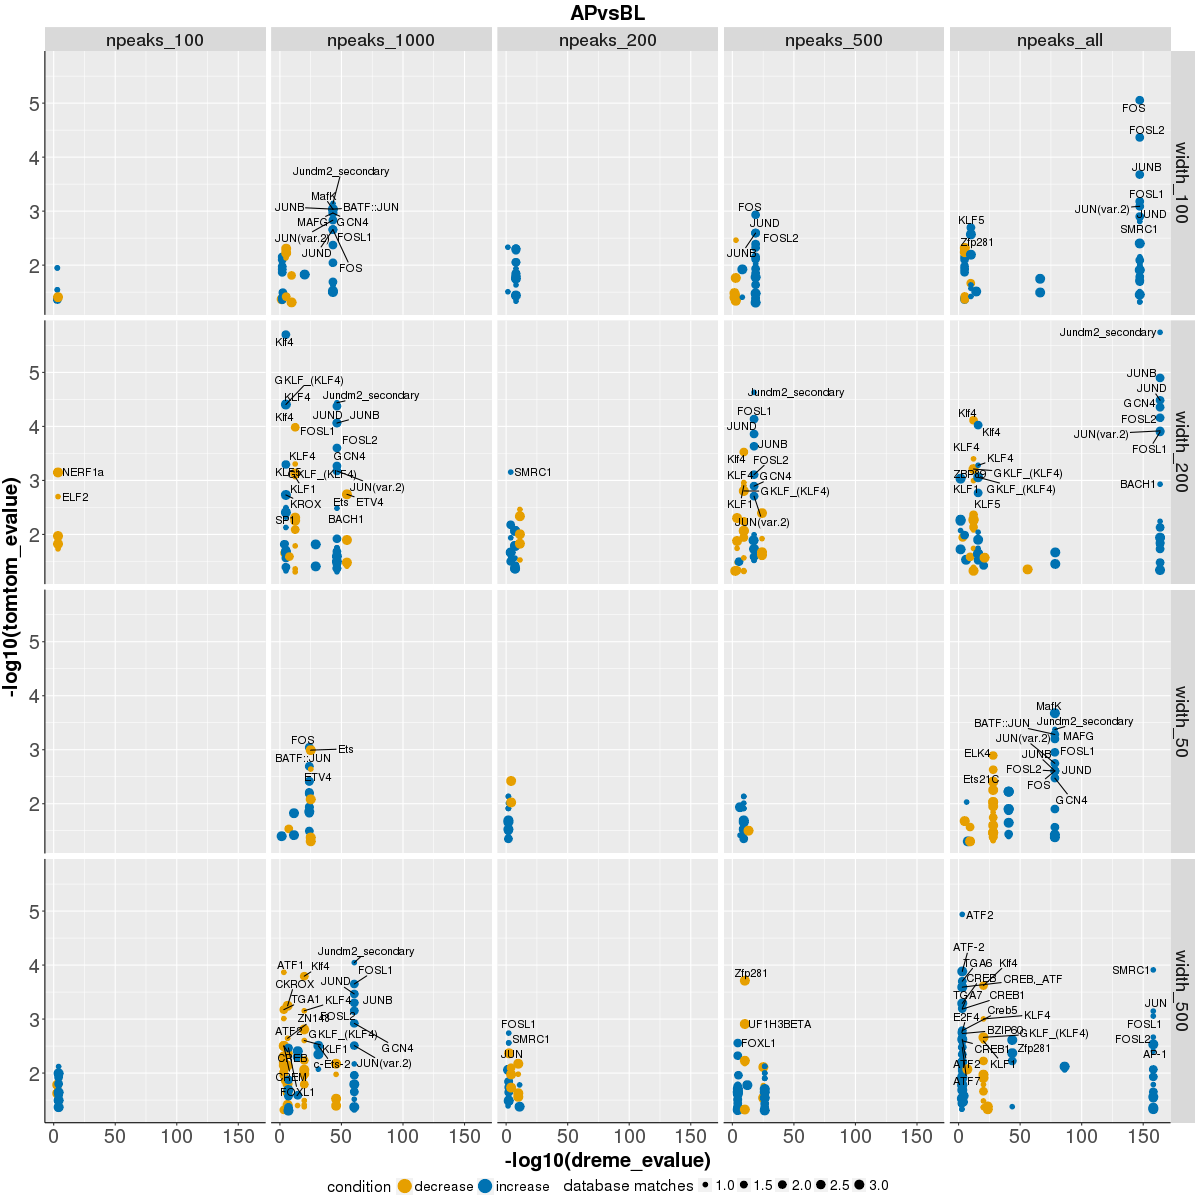

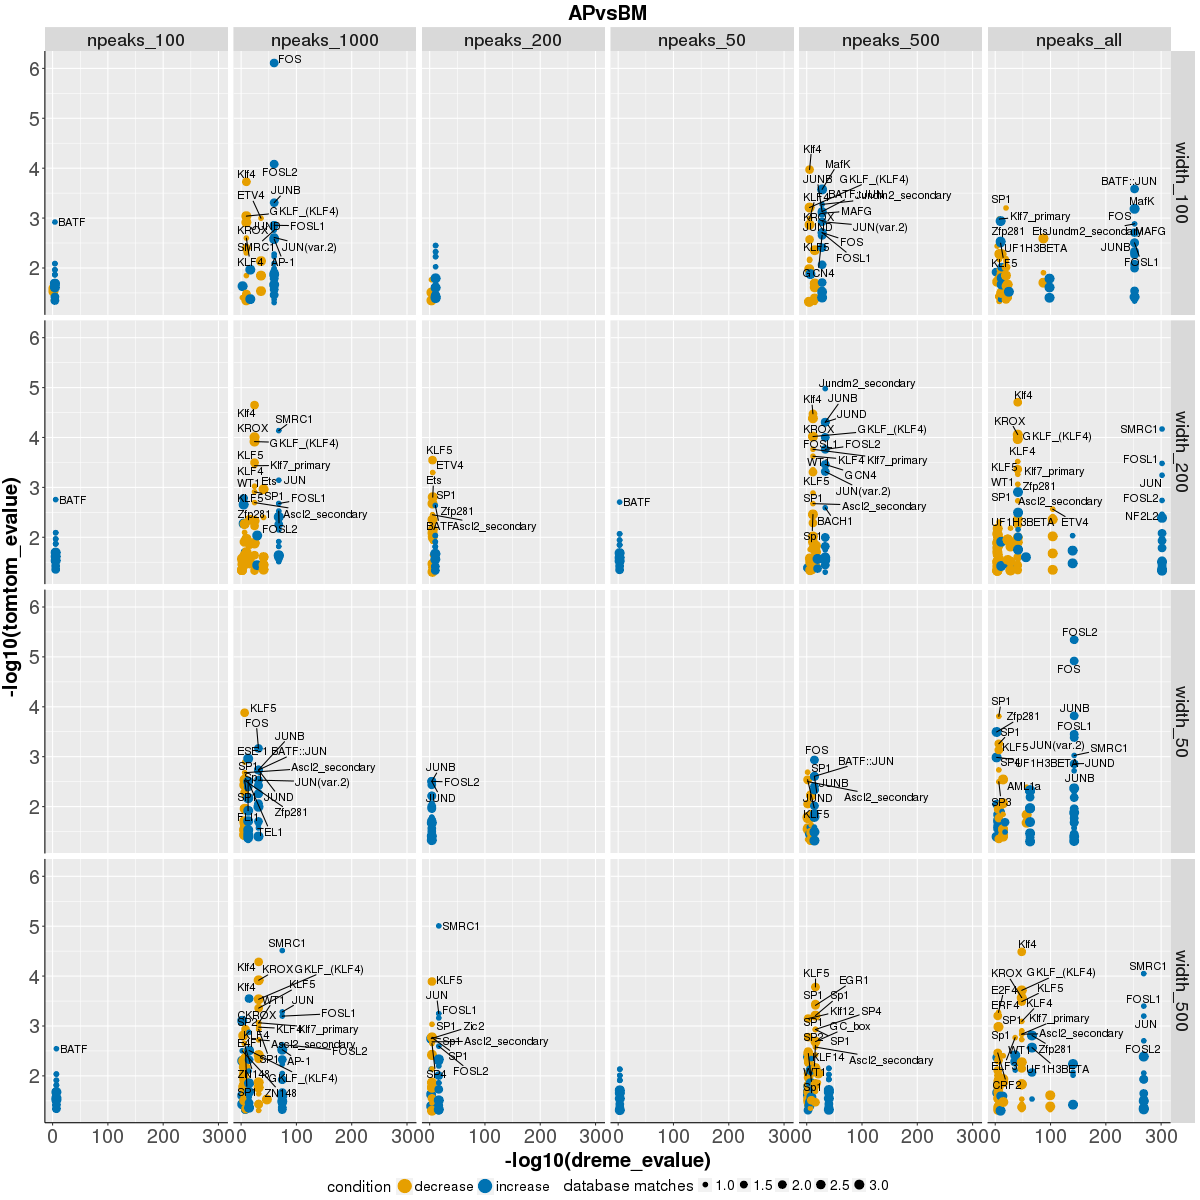

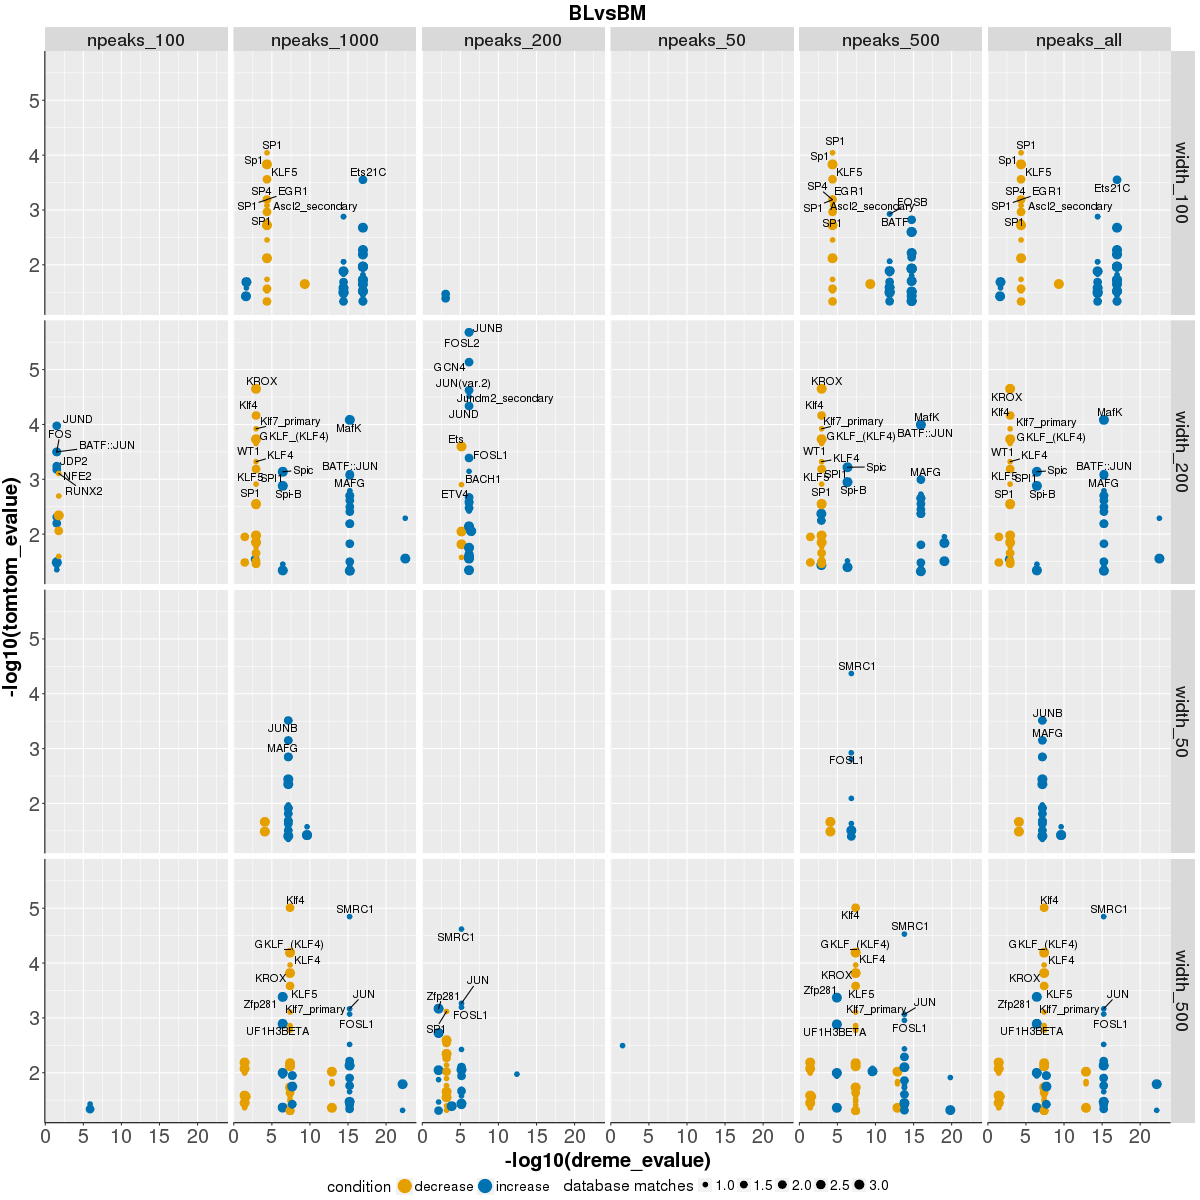

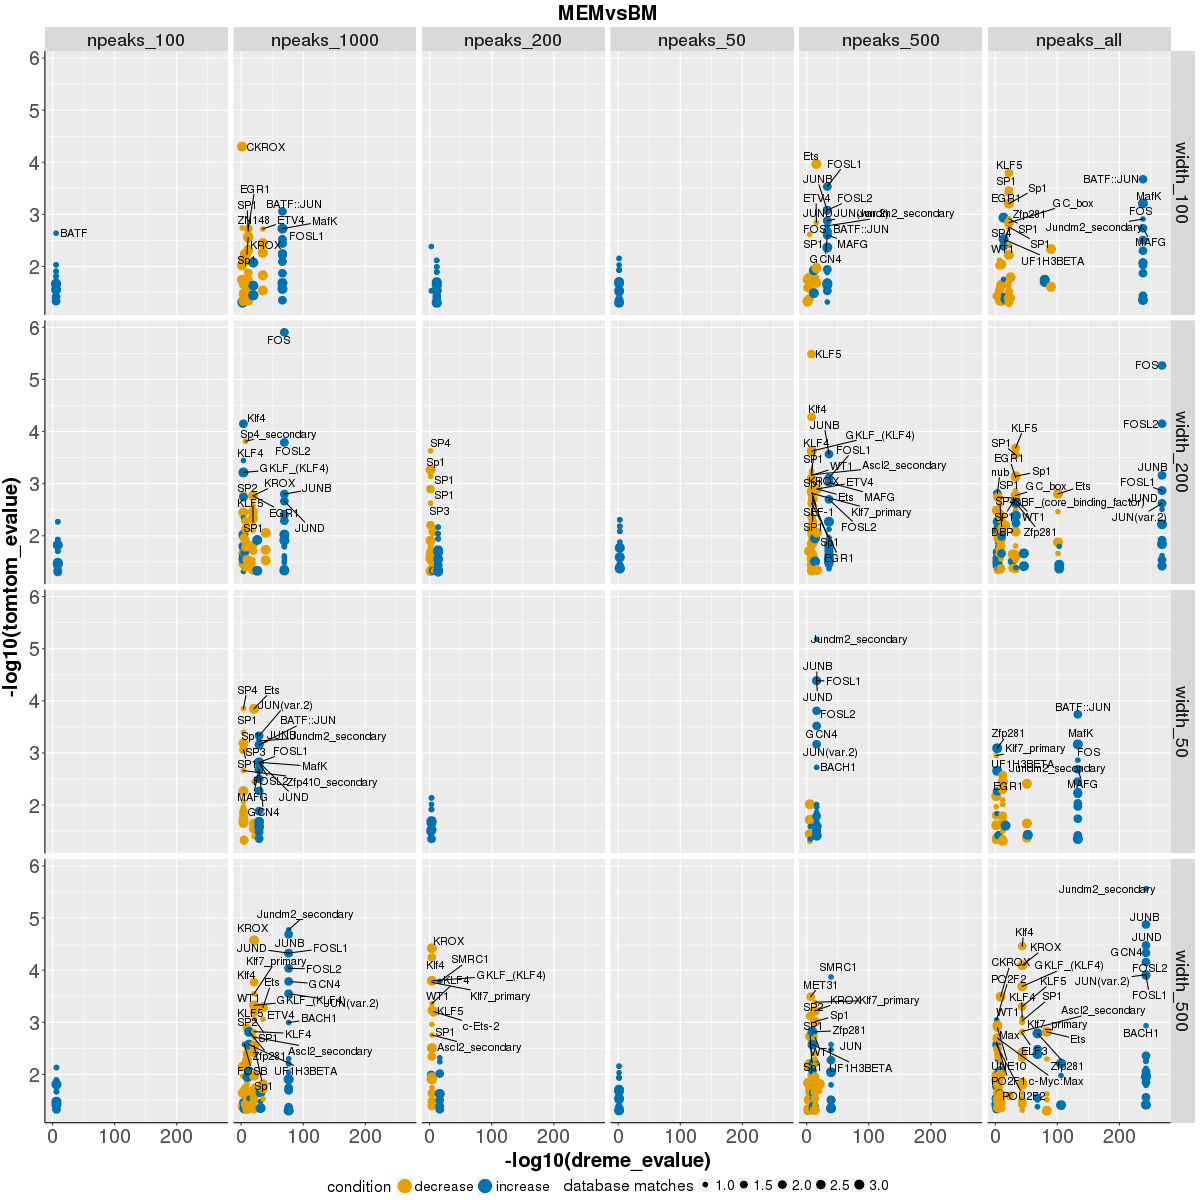

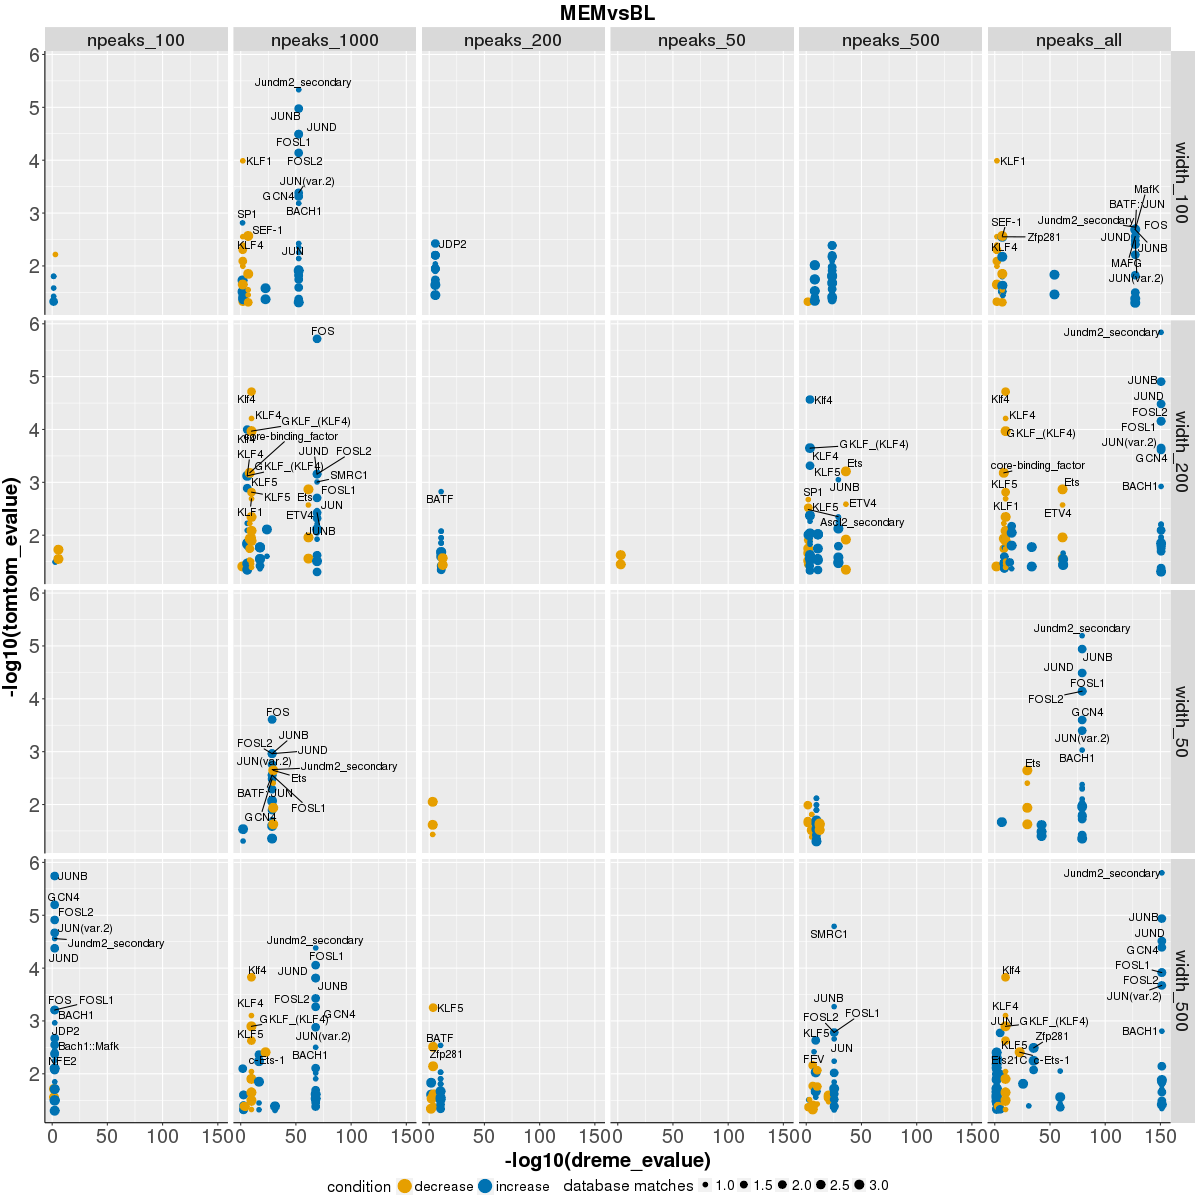

In [16]:
%%R -i dreme_graph -w 1200 -h 1200

for (comp in unique(dreme_graph$DESeq2_comparison)){
    df <- subset(dreme_graph, DESeq2_comparison == comp)

    p <- ggplot(df, aes(y=-log10(tomtom_evalue), x=-log10(dreme_evalue), colour=condition)) +
        geom_point(aes(size=database), position=position_jitterdodge()) + 
        scale_size(range=c(2,4), name="database matches") +
        scale_alpha(range=c(0.4,1)) +
        geom_text_repel(data=df[-log10(df$"tomtom_evalue") > 
                                       quantile(-log10(df$"tomtom_evalue"), 0.8, na.rm=T), ], 
                        aes(y=-log10(tomtom_evalue), x=-log10(dreme_evalue), label=motif_name), colour="black", alpha=1) +
        facet_grid(width ~ peaks) +
        theme(legend.position="bottom", legend.direction="horizontal") +
        scale_colour_manual(values=Palette) +
        guides(color=guide_legend(override.aes=list(size=6))) +
        guides(alpha=guide_legend(override.aes=list(size=6)))  +
        labs(title=comp)
    
    grid.arrange(p, ncol=1, nrow=1)
}

***
<br>
### Top TF Matches for Discovered Motifs
- For each motif found by dreme the top 5 database matches are shown

In [22]:
dreme_chip.head()

motif  motif_rc  pos  neg  dreme_evalue                        run  \
60484  RTGASTMA  TKASTCAY  486  106  3.100000e-77  MEMvsBM_increase_1000_500   
60485  RTGASTMA  TKASTCAY  486  106  3.100000e-77  MEMvsBM_increase_1000_500   
60486  RTGASTMA  TKASTCAY  486  106  3.100000e-77  MEMvsBM_increase_1000_500   
60487  RTGASTMA  TKASTCAY  486  106  3.100000e-77  MEMvsBM_increase_1000_500   
60488  RTGASTMA  TKASTCAY  486  106  3.100000e-77  MEMvsBM_increase_1000_500   

      query_consensus  target_id        motif_name  database  tomtom_evalue  \
60484        GTGACTCA  UP00103_2  Jundm2_secondary  uniprobe       0.000017   
60485        GTGACTCA   MA0490.1              JUNB    jaspar       0.000021   
60486        GTGACTCA   MA0490.1              JUNB  uniprobe       0.000021   
60487        GTGACTCA   MA0477.1             FOSL1    jaspar       0.000047   
60488        GTGACTCA   MA0477.1             FOSL1  uniprobe       0.000047   

      orientation DESeq2_comparison condition no_peaks window  settings  
60484           -           MEMvsBM  increase     1000    500  1000_500  
60485           +           MEMvsBM  increase     1000    500  1000_500  
60486           +           MEMvsBM  increase     1000    500  1000_500  
60487           +           MEMvsBM  increase     1000    500  1000_500  
60488           +           MEMvsBM  increase     1000    500  1000_500

In [23]:
tfs = dreme_chip.groupby(["motif", "DESeq2_comparison", "condition", "query_consensus",
                          "dreme_evalue", "tomtom_evalue", "settings"])["motif_name"].unique()
tfs = pd.DataFrame(tfs)
tfs.reset_index(inplace=True)
tfs["motif_name"] = tfs["motif_name"].apply(lambda x:''.join(x))
tfs["motif"] = tfs["motif"].astype(str)
tfs = tfs.groupby(["motif", "settings"]).head(5) # get top 5 db matches for each discovered motif

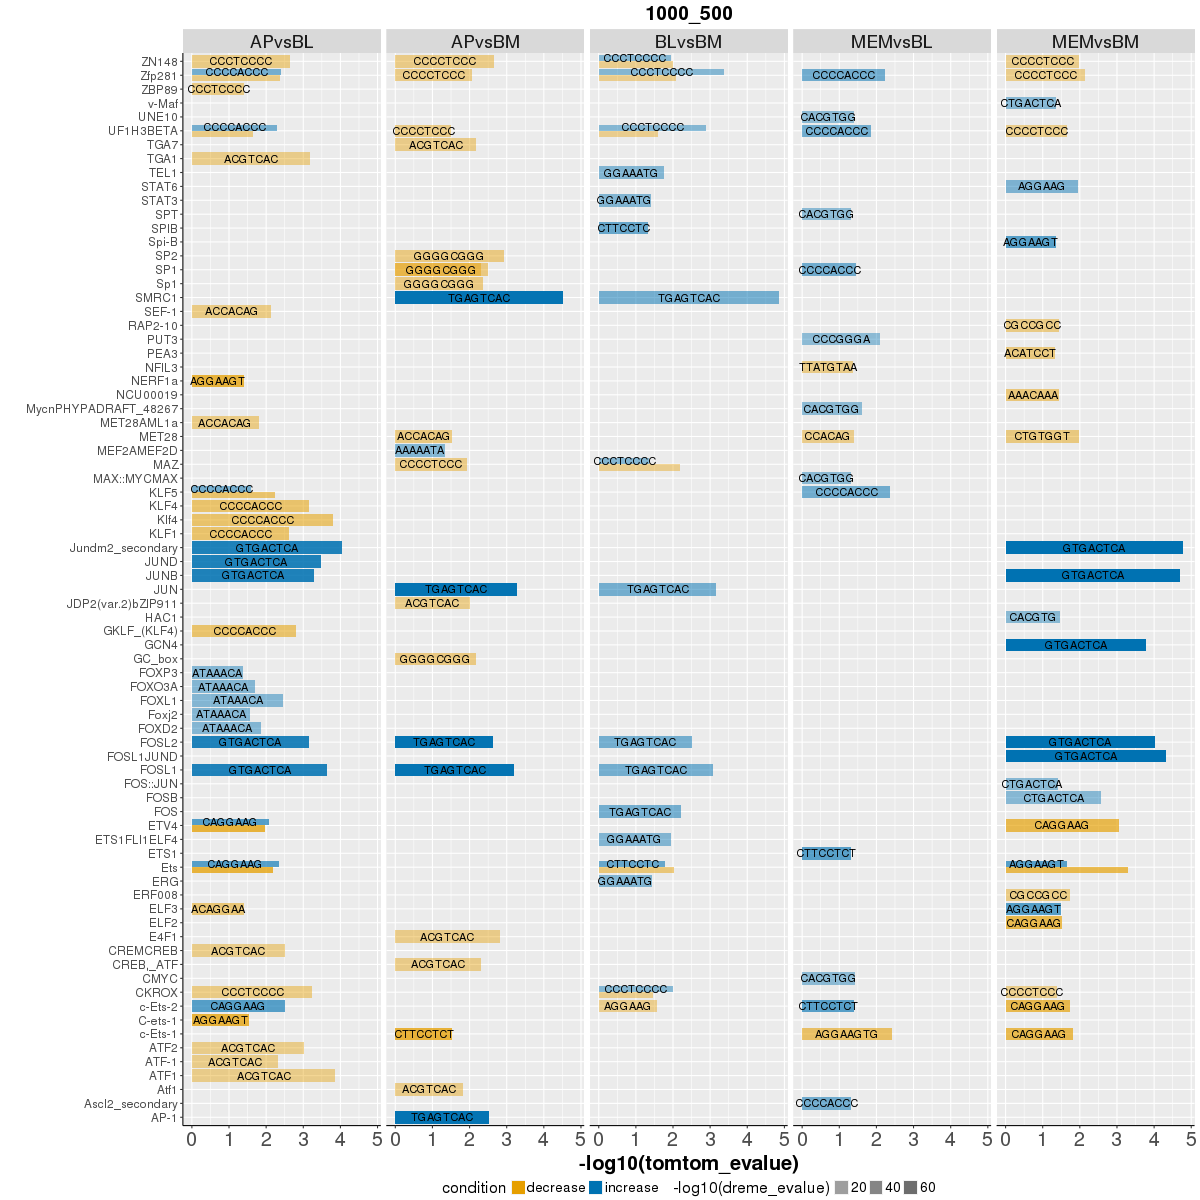

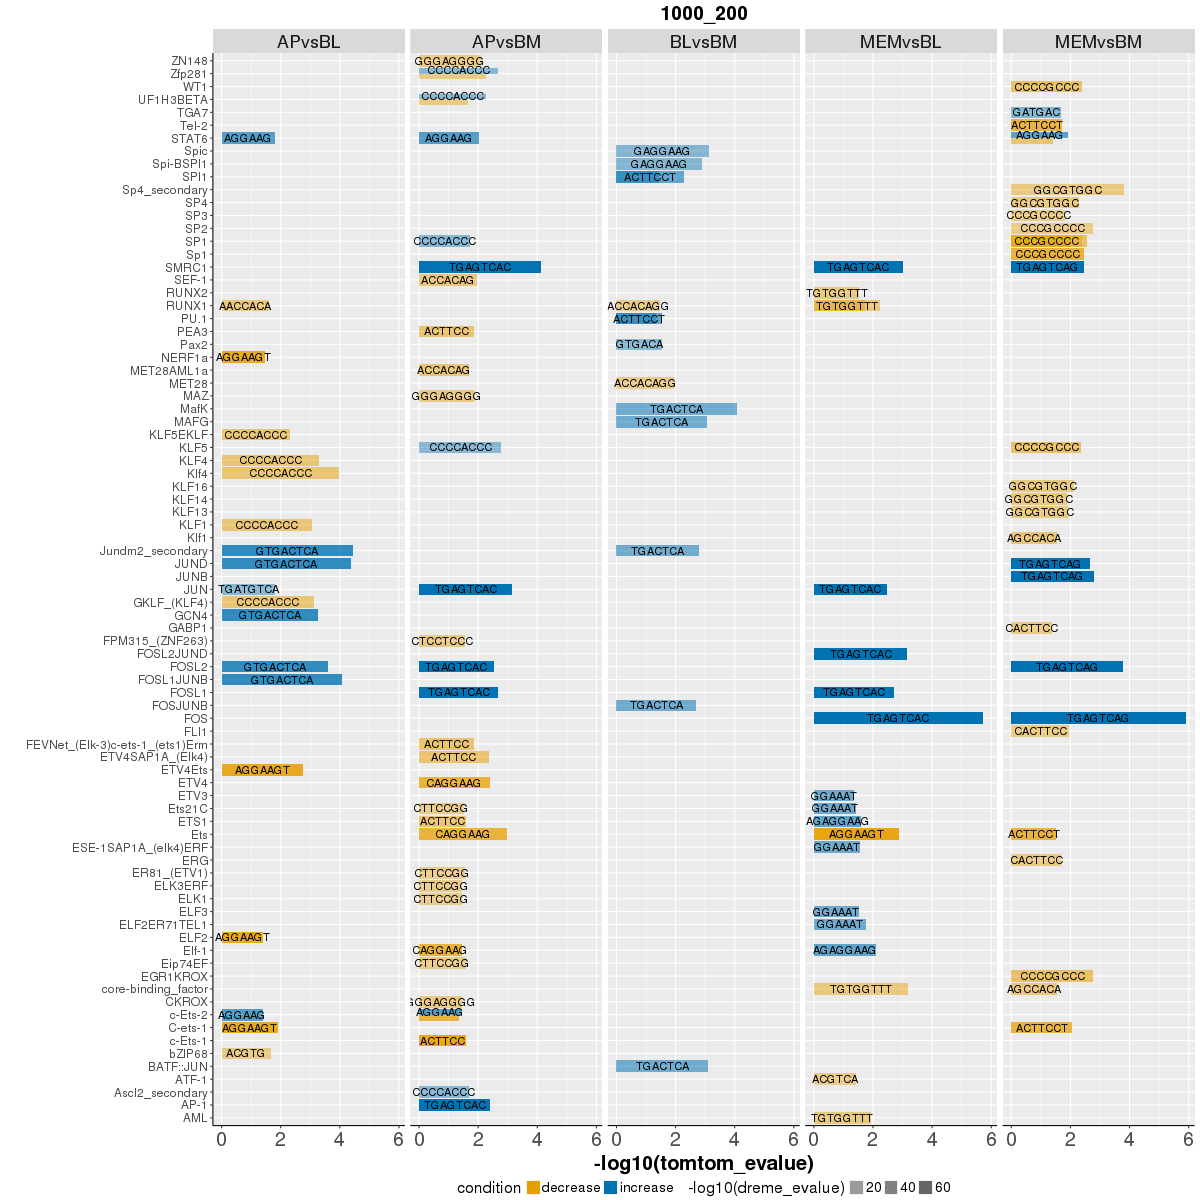

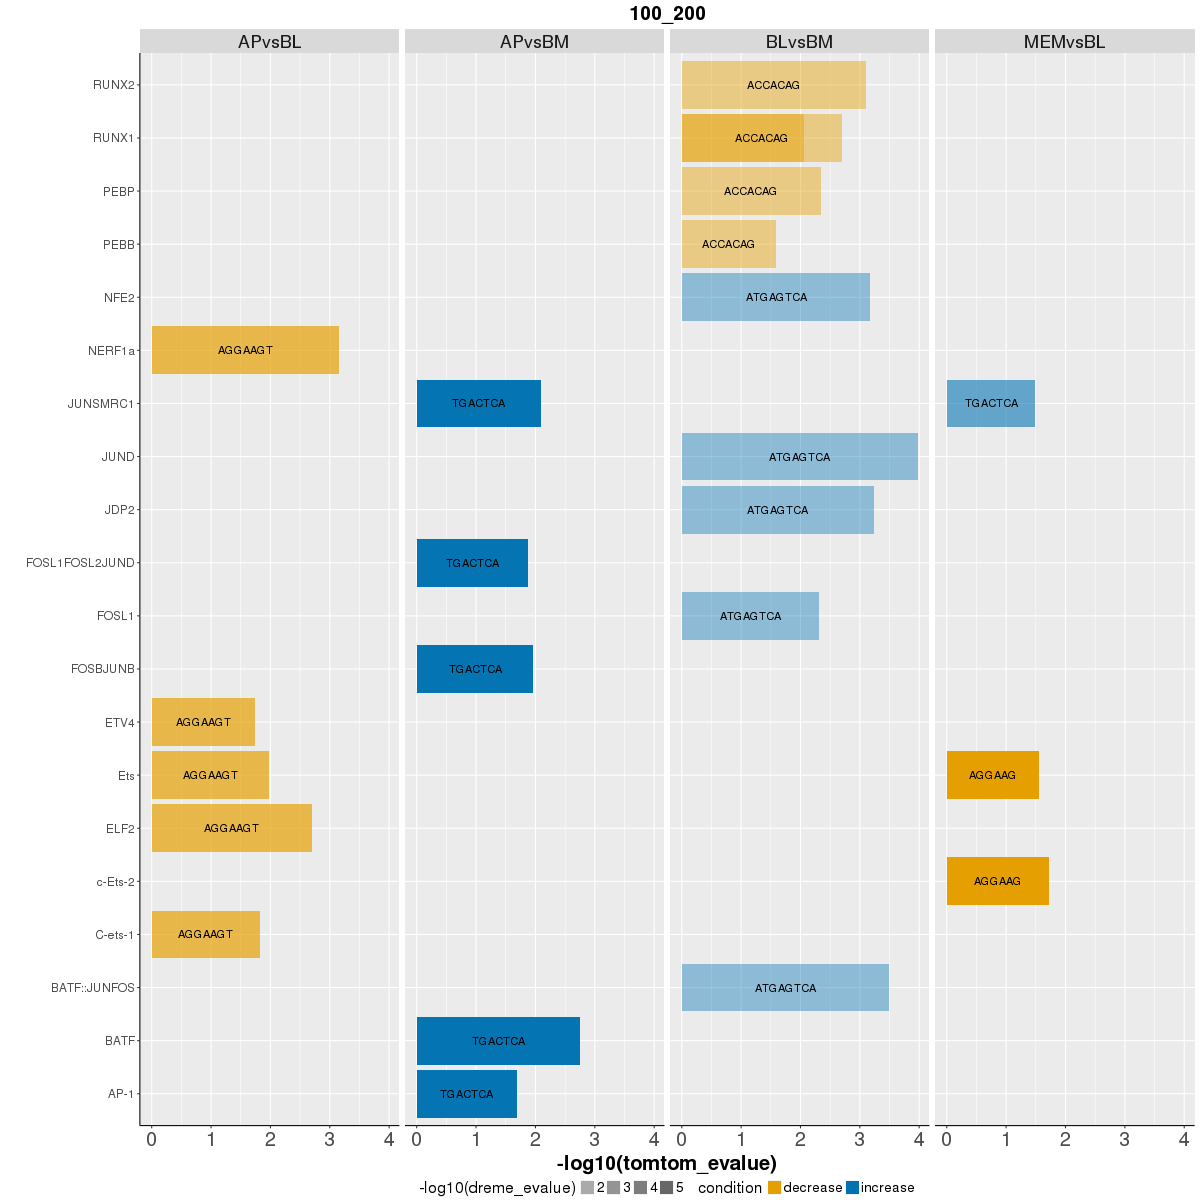

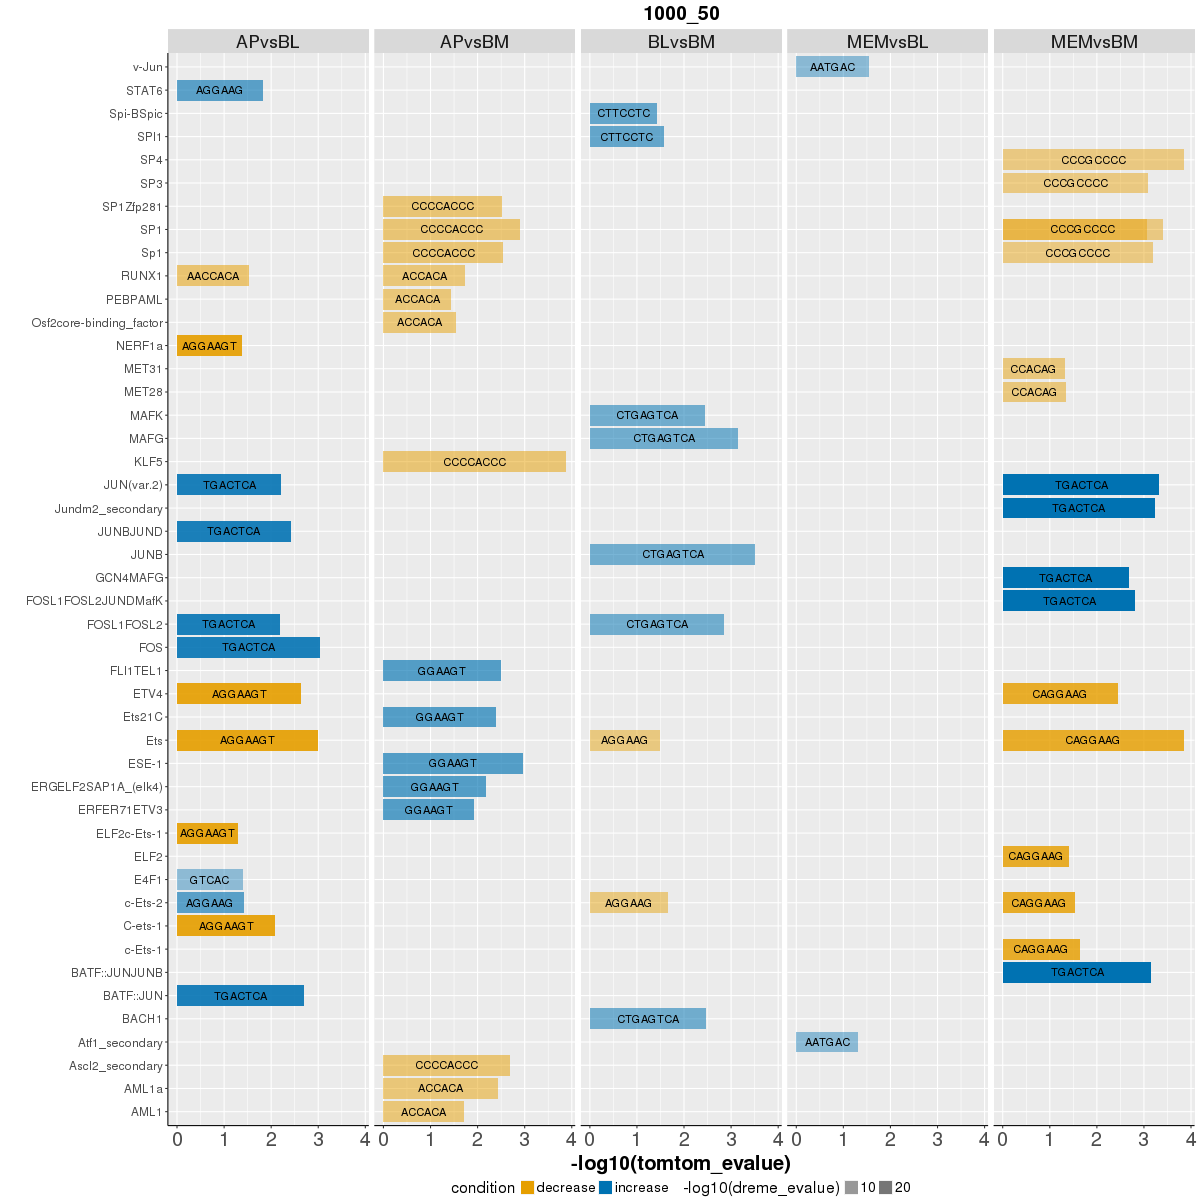

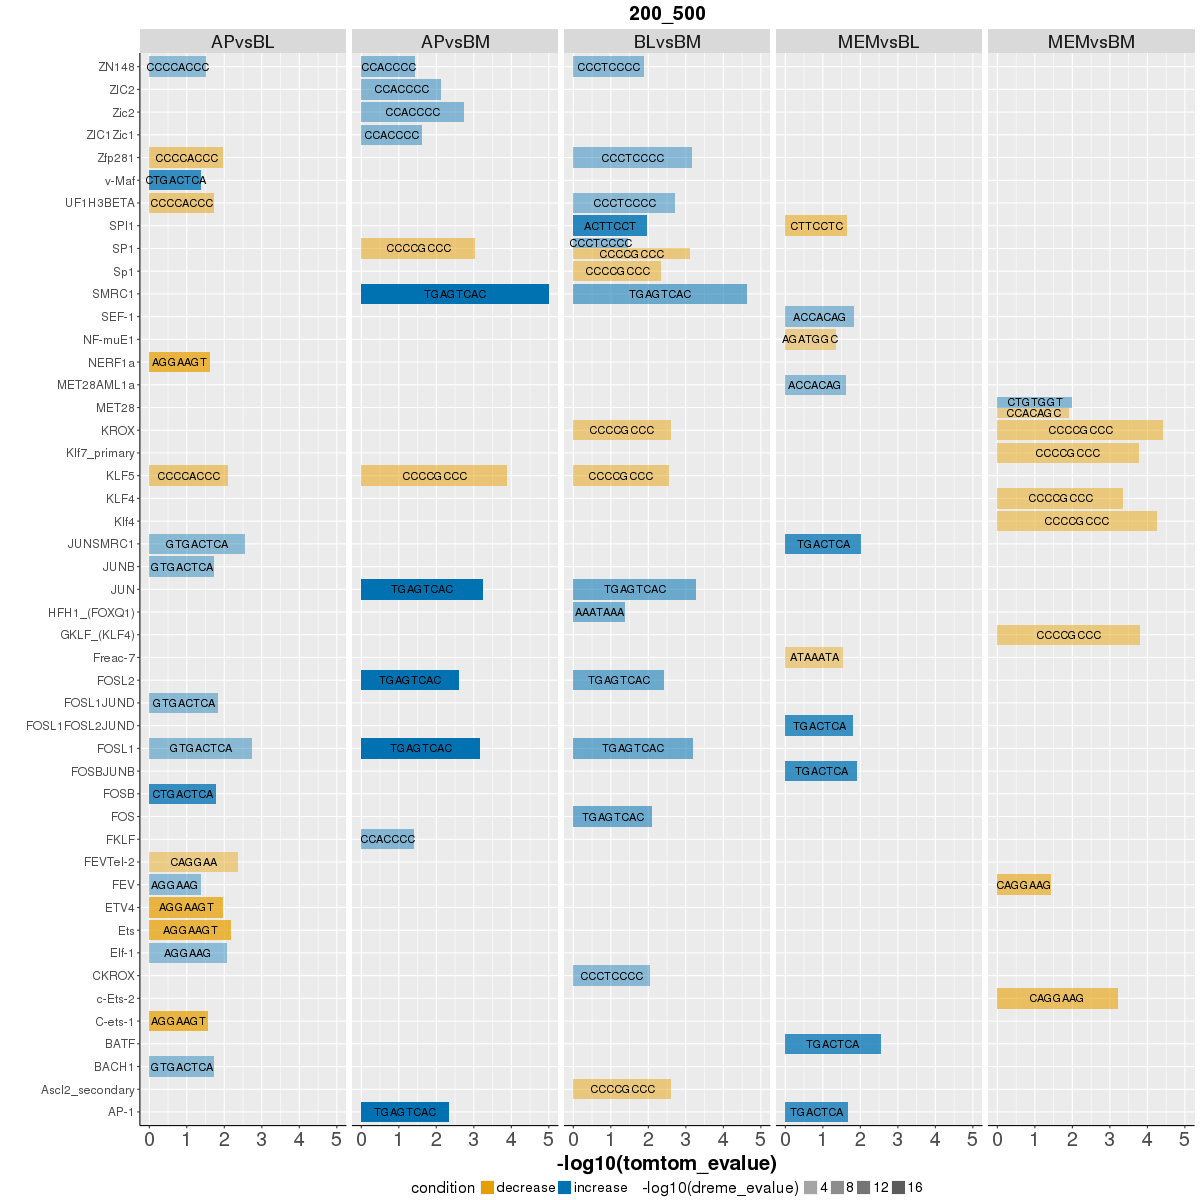

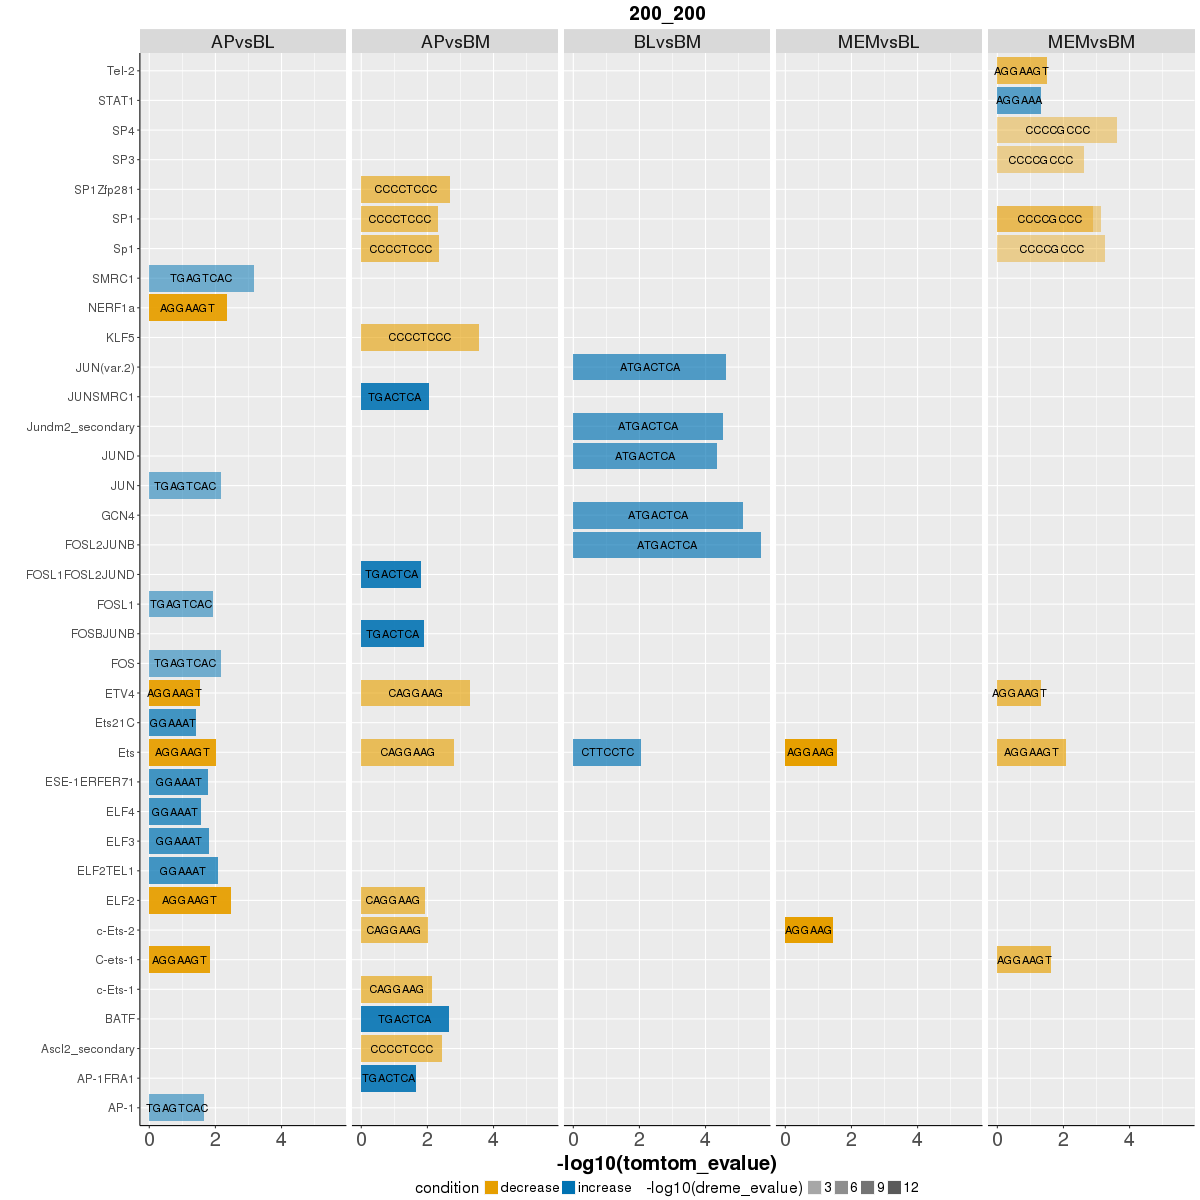

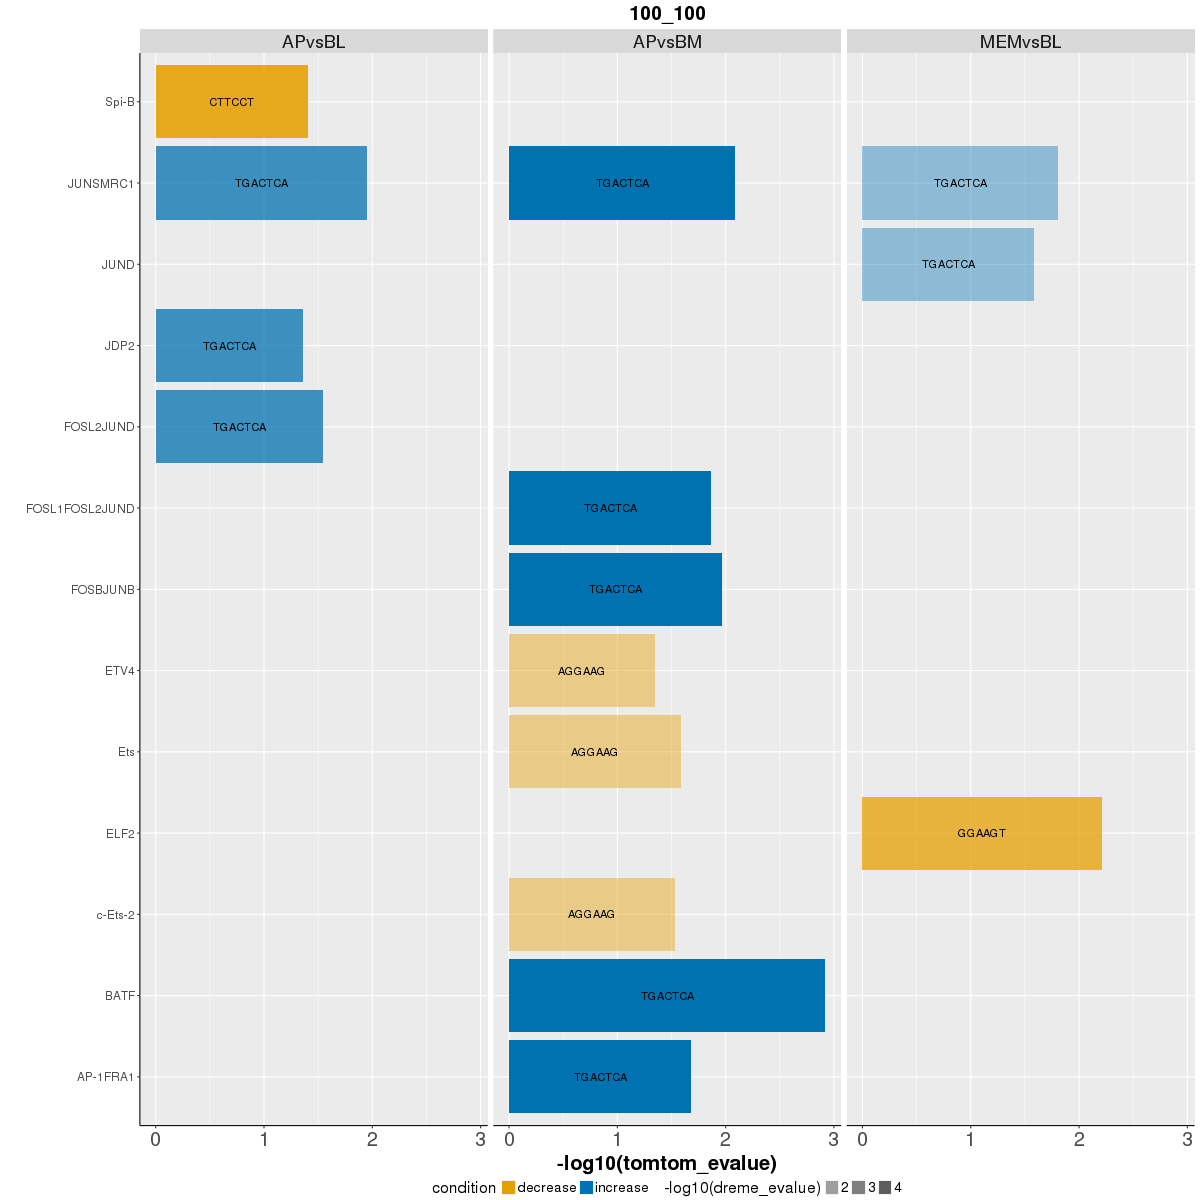

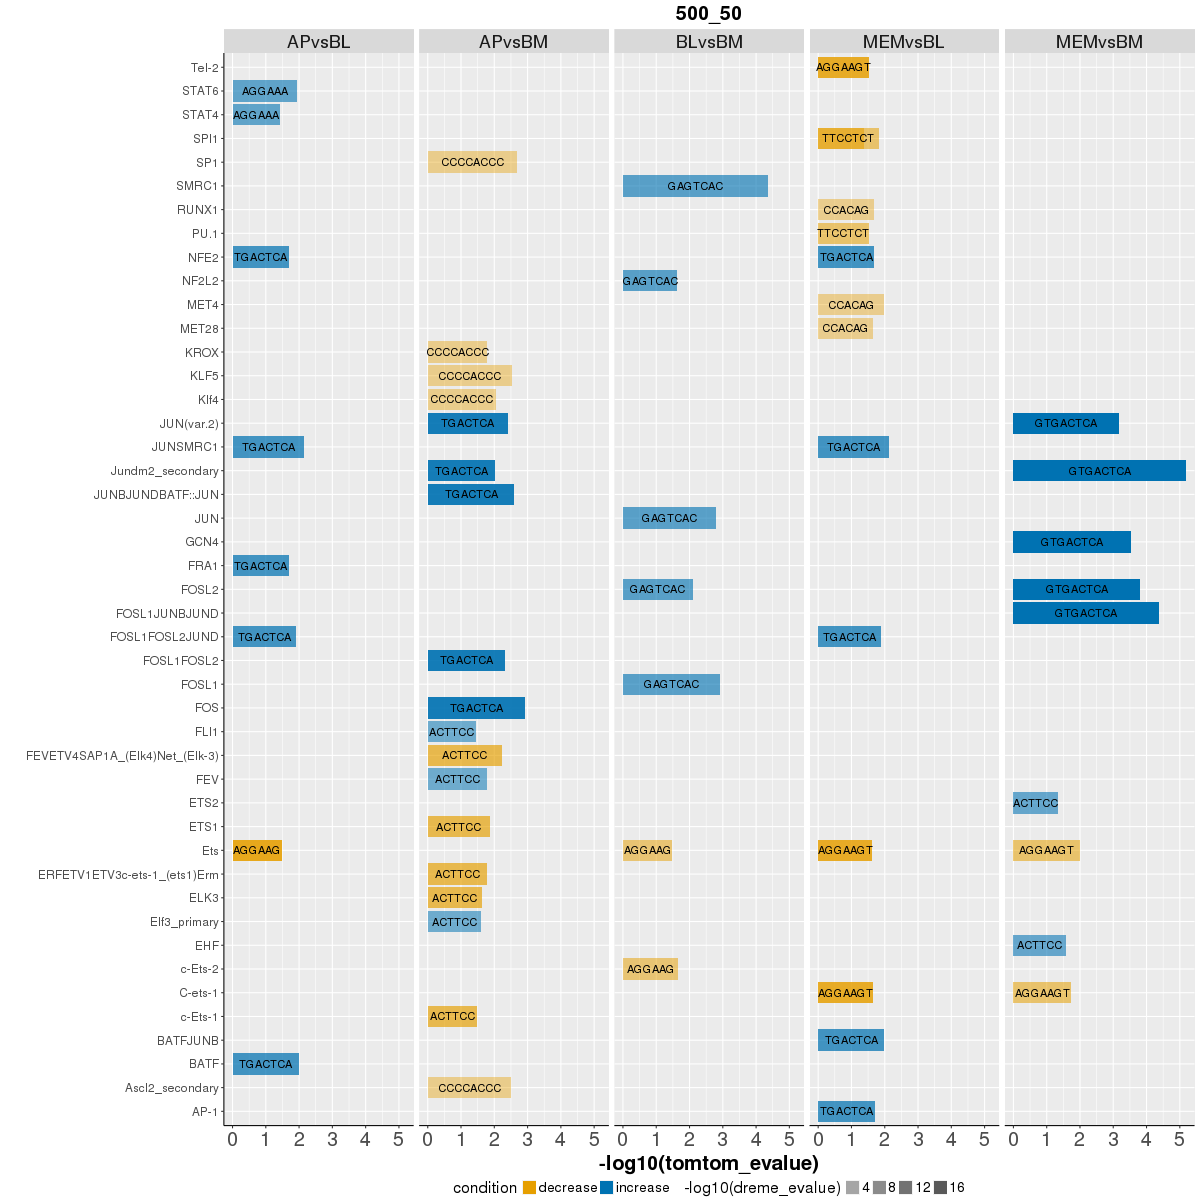

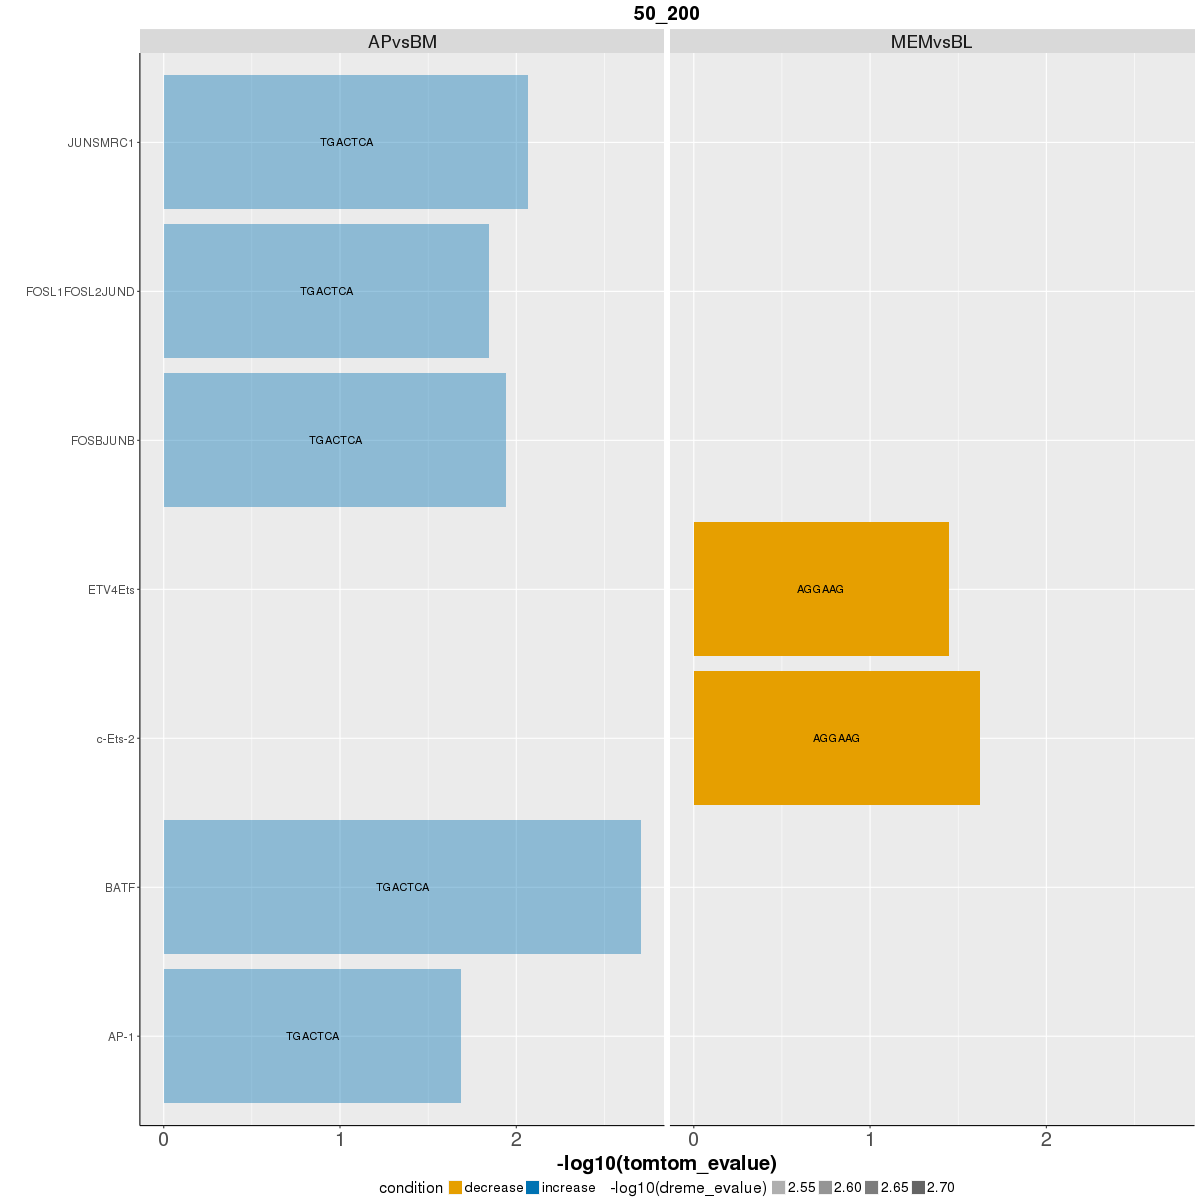

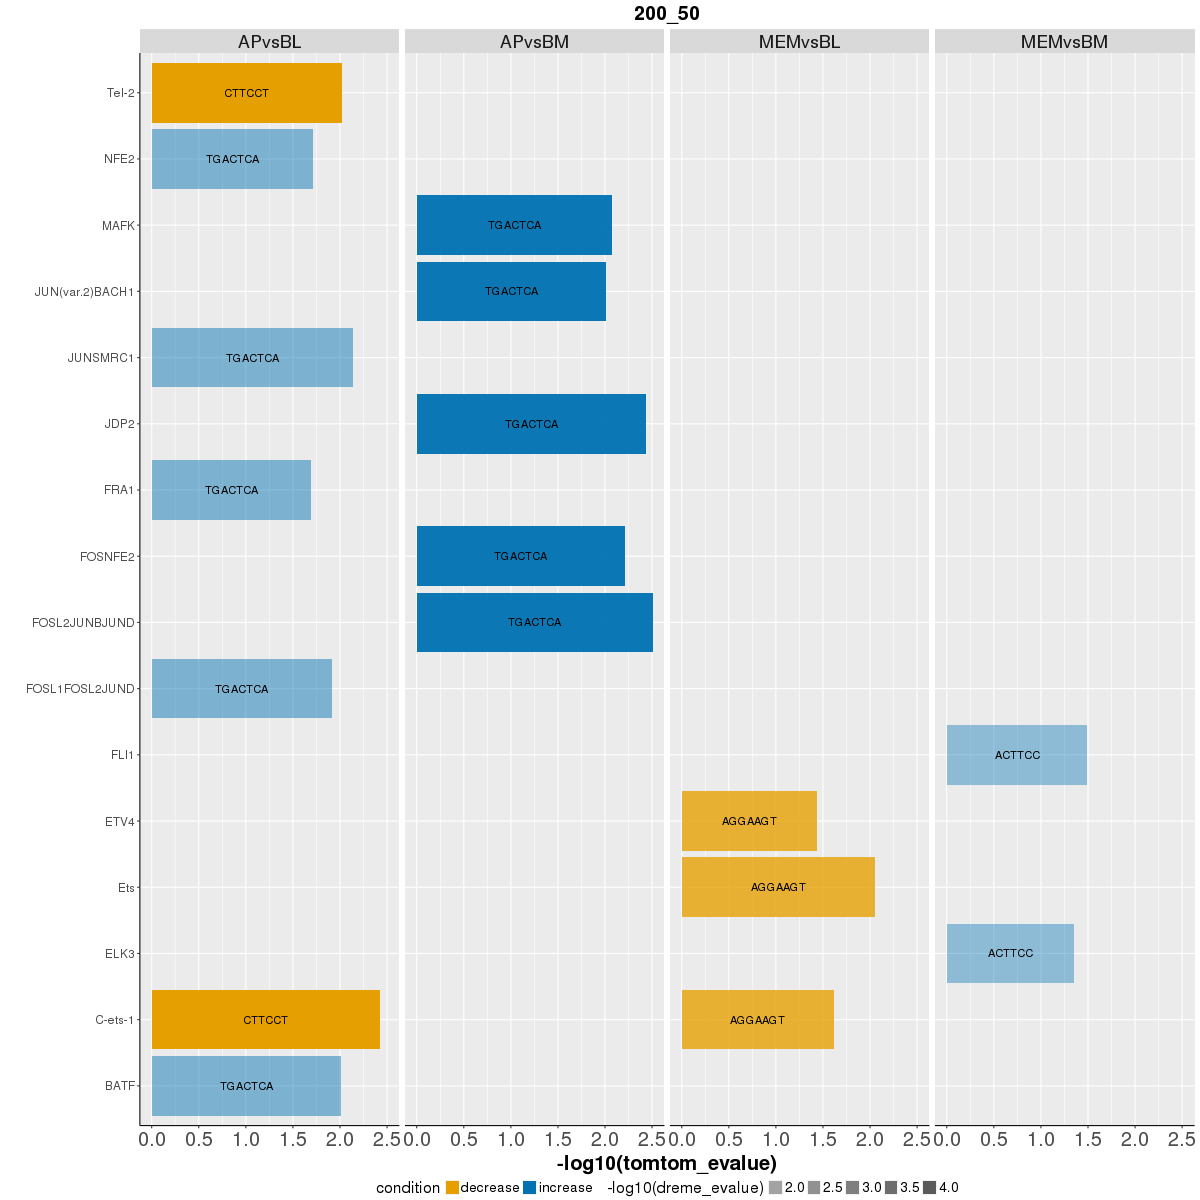

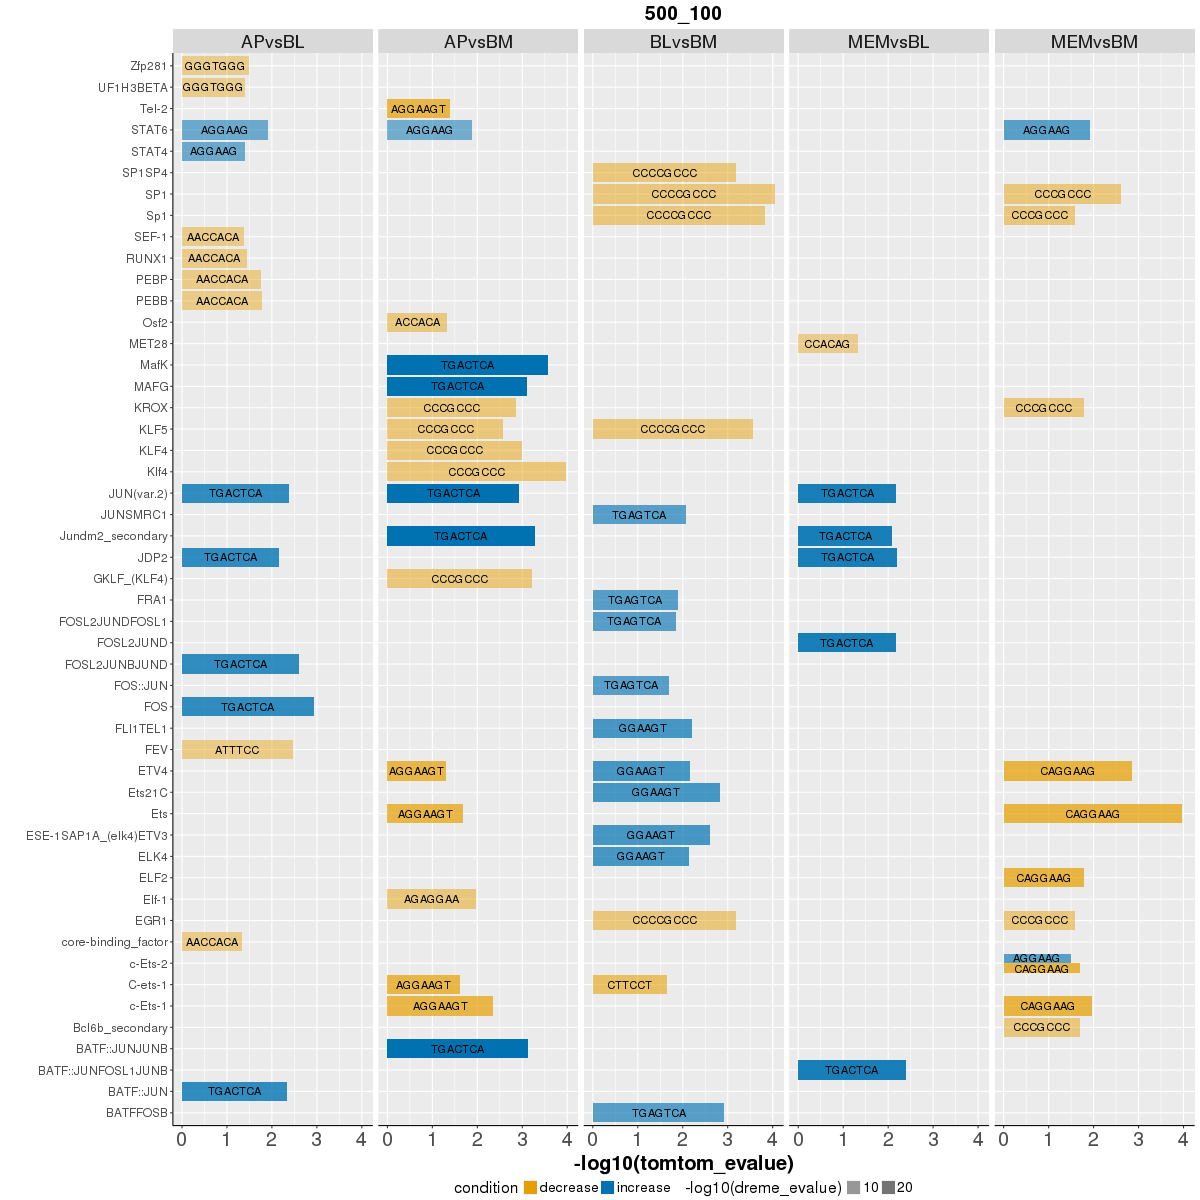

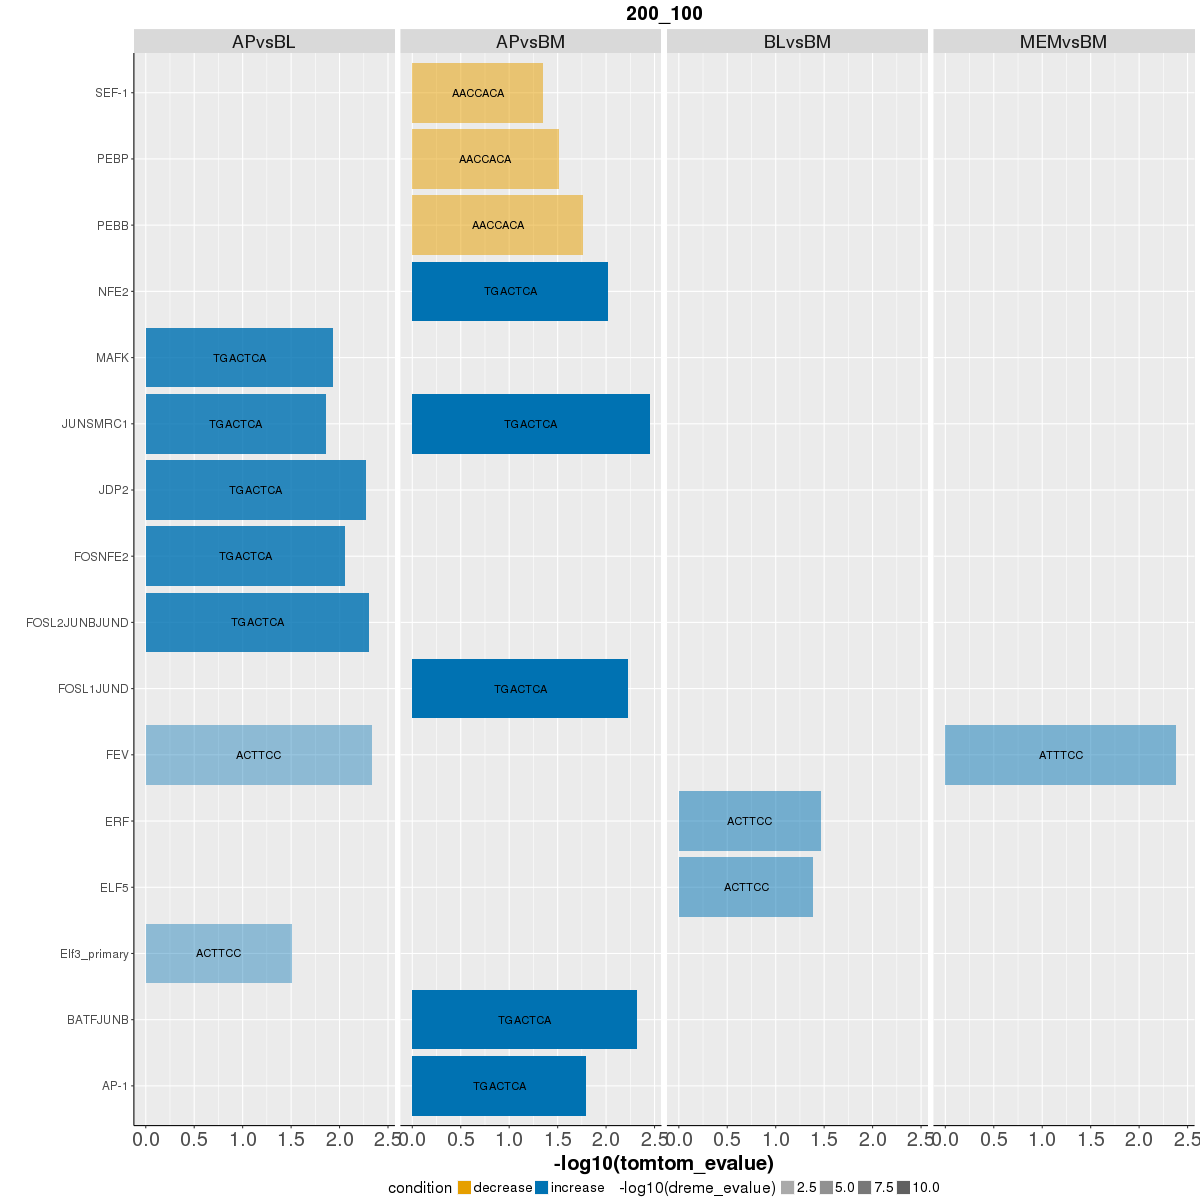

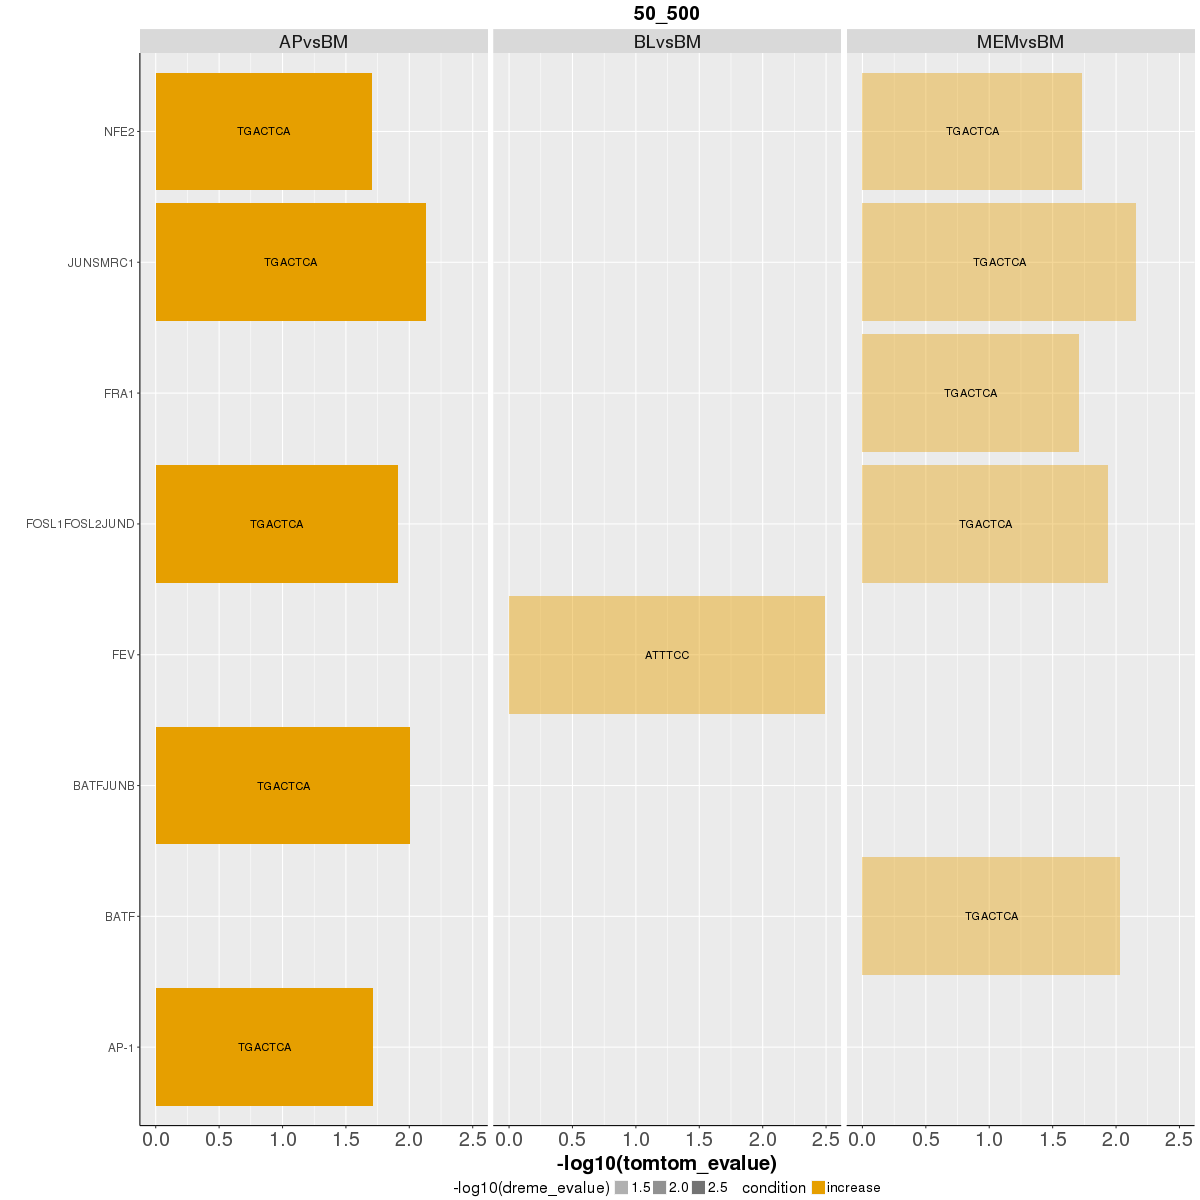

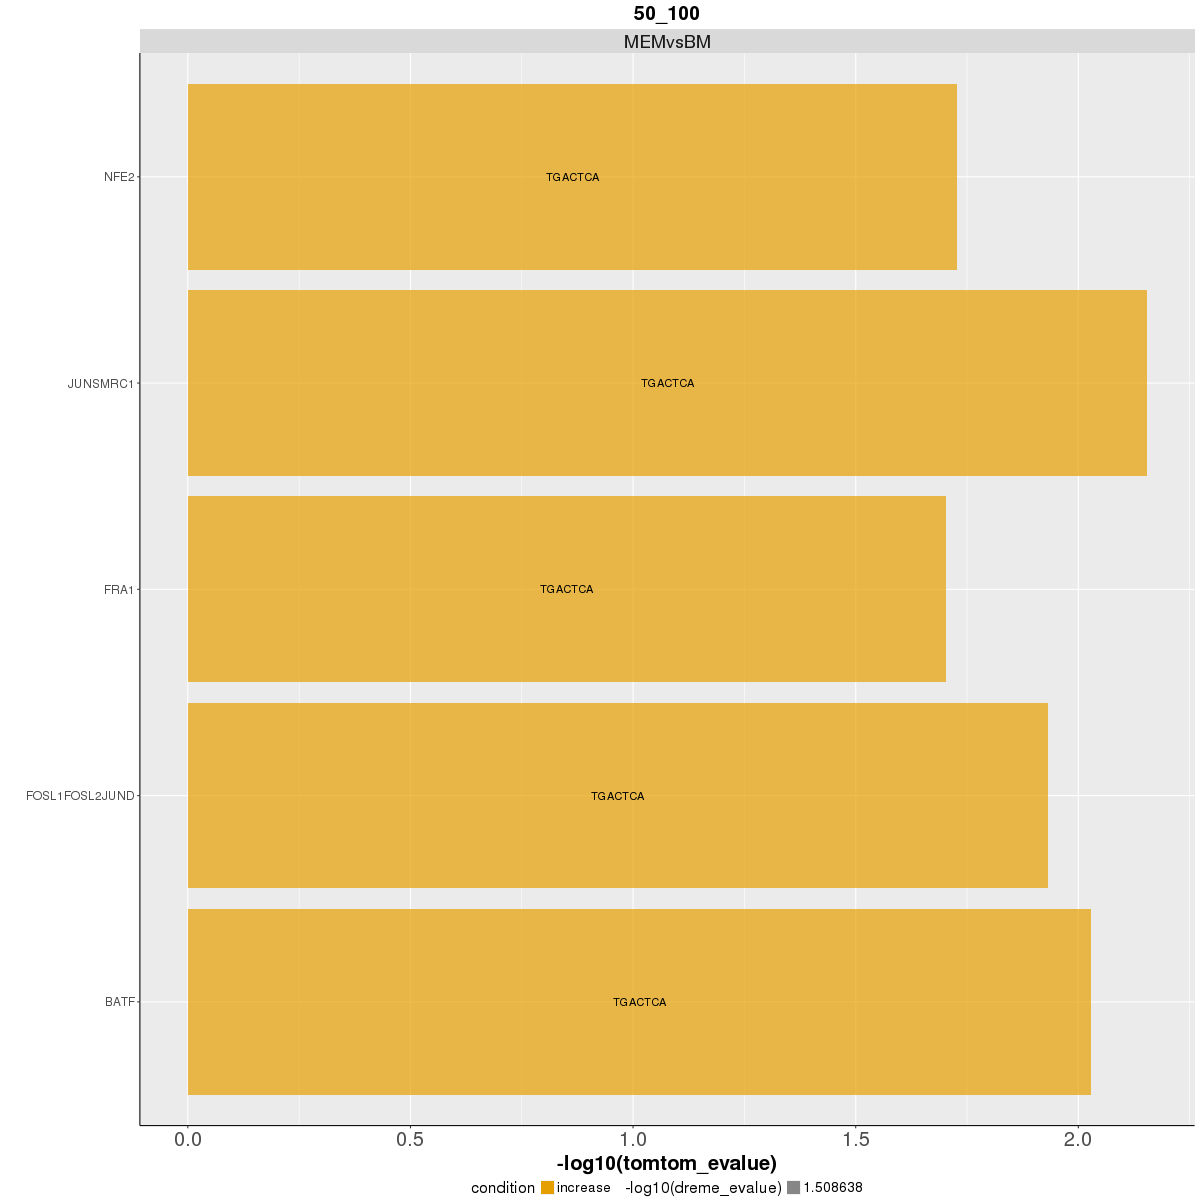

In [26]:
%%R -i tfs -w 1200 -h 1200

settings <- unique(tfs$settings)

for (setting in settings){
    p <- ggplot(subset(tfs, settings == setting), 
                aes(y=-log10(tomtom_evalue), x=motif_name, fill=condition, alpha=-log10(dreme_evalue))) + 
            geom_bar(stat="identity", position="dodge") + 
            geom_text(aes(label=query_consensus, y=-log10(tomtom_evalue)/2), 
                      alpha=1, check_overlap=TRUE, position=position_dodge(width=1)) +
            coord_flip() +
            scale_alpha(range=c(0.4,1 )) +
            facet_wrap( ~ DESeq2_comparison, nrow=1) +
            theme(axis.text.y=element_text(size=12)) +
            scale_fill_manual(values=Palette) +
            theme(legend.position="bottom", legend.direction="horizontal") +
            labs(title=setting, x="")

    grid.arrange(p, ncol=1, nrow=1)
}


<br>
## Top Motif Tables:
* Sorted by peak size & TOMTOM e-value

### Peaks with increased accessibility:

In [19]:
for i in dreme_chip["DESeq2_comparison"].unique():
    print i
    dreme_chip[(dreme_chip.DESeq2_comparison == i) & (dreme_chip.condition == "increase")].sort_values(["window", "tomtom_evalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(10)

APvsBM


motif  motif_rc   pos  neg   dreme_evalue                       run  \
32576  TGASTMAB  VTKASTCA   301   33   2.000000e-60  APvsBM_increase_1000_100   
32578  TGASTMAB  VTKASTCA   301   33   2.000000e-60  APvsBM_increase_1000_100   
36596   TGAVTMA   TKABTCA  1572  296  1.100000e-252   APvsBM_increase_all_100   
29416   TGASTMA   TKASTCA   151   17   1.500000e-28   APvsBM_increase_500_100   
32580  TGASTMAB  VTKASTCA   301   33   2.000000e-60  APvsBM_increase_1000_100   
29419   TGASTMA   TKASTCA   151   17   1.500000e-28   APvsBM_increase_500_100   
29424   TGASTMA   TKASTCA   151   17   1.500000e-28   APvsBM_increase_500_100   
37256  CCCCDCCC  GGGHGGGG   213   83   1.900000e-10   APvsBM_increase_all_100   
29426   TGASTMA   TKASTCA   151   17   1.500000e-28   APvsBM_increase_500_100   
26076   TGACTMA   TKAGTCA    31    2   7.400000e-05   APvsBM_increase_100_100   

      query_consensus           target_id        motif_name  database  \
32576        TGAGTCAG            MA0476.1               FOS    jaspar   
32578        TGAGTCAG            MA0478.1             FOSL2    jaspar   
36596         TGACTCA            MA0462.1         BATF::JUN    jaspar   
29416         TGACTCA              M02022              MafK  transfac   
32580        TGAGTCAG            MA0490.1              JUNB    jaspar   
29419         TGACTCA           UP00103_2  Jundm2_secondary  uniprobe   
29424         TGACTCA            MA0659.1              MAFG    jaspar   
37256        CCCCACCC              M01597            Zfp281  transfac   
29426         TGACTCA            MA0489.1        JUN(var.2)    jaspar   
26076         TGACTCA  BATF_MOUSE.H10MO.B              BATF  hocomoco   

       tomtom_evalue orientation DESeq2_comparison condition no_peaks window  \
32576   7.803610e-07           -            APvsBM  increase     1000    100   
32578   8.294430e-05           +            APvsBM  increase     1000    100   
36596   2.612340e-04           +            APvsBM  increase      all    100   
29416   2.663200e-04           -            APvsBM  increase      500    100   
32580   4.922170e-04           +            APvsBM  increase     1000    100   
29419   5.326390e-04           -            APvsBM  increase      500    100   
29424   7.989590e-04           -            APvsBM  increase      500    100   
37256   1.146570e-03           -            APvsBM  increase      all    100   
29426   1.183940e-03           +            APvsBM  increase      500    100   
26076   1.201250e-03           -            APvsBM  increase      100    100   

       settings  
32576  1000_100  
32578  1000_100  
36596   all_100  
29416   500_100  
32580  1000_100  
29419   500_100  
29424   500_100  
37256   all_100  
29426   500_100  
26076   100_100

MEMvsBM


motif  motif_rc   pos  neg   dreme_evalue                       run  \
90548   TGAVTMA   TKABTCA  1384  234  1.200000e-238  MEMvsBM_increase_all_100   
83584   TGASTMA   TKASTCA   162   15   7.000000e-34  MEMvsBM_increase_500_100   
90550   TGAVTMA   TKABTCA  1384  234  1.200000e-238  MEMvsBM_increase_all_100   
90552   TGAVTMA   TKABTCA  1384  234  1.200000e-238  MEMvsBM_increase_all_100   
83586   TGASTMA   TKASTCA   162   15   7.000000e-34  MEMvsBM_increase_500_100   
83588   TGASTMA   TKASTCA   162   15   7.000000e-34  MEMvsBM_increase_500_100   
83590   TGASTMA   TKASTCA   162   15   7.000000e-34  MEMvsBM_increase_500_100   
91148  CCCCDCCC  GGGHGGGG   197   61   4.300000e-14  MEMvsBM_increase_all_100   
90555   TGAVTMA   TKABTCA  1384  234  1.200000e-238  MEMvsBM_increase_all_100   
83592   TGASTMA   TKASTCA   162   15   7.000000e-34  MEMvsBM_increase_500_100   

      query_consensus  target_id        motif_name  database  tomtom_evalue  \
90548         TGACTCA   MA0462.1         BATF::JUN    jaspar       0.000212   
83584         TGACTCA   MA0477.1             FOSL1    jaspar       0.000293   
90550         TGACTCA   MA0476.1               FOS    jaspar       0.000615   
90552         TGACTCA     M02022              MafK  transfac       0.000615   
83586         TGACTCA   MA0478.1             FOSL2    jaspar       0.000832   
83588         TGACTCA   MA0490.1              JUNB    jaspar       0.000832   
83590         TGACTCA   MA0491.1              JUND    jaspar       0.000832   
91148        CCCCACCC     M01597            Zfp281  transfac       0.001157   
90555         TGACTCA  UP00103_2  Jundm2_secondary  uniprobe       0.001230   
83592         TGACTCA   MA0489.1        JUN(var.2)    jaspar       0.001331   

      orientation DESeq2_comparison condition no_peaks window settings  
90548           +           MEMvsBM  increase      all    100  all_100  
83584           +           MEMvsBM  increase      500    100  500_100  
90550           -           MEMvsBM  increase      all    100  all_100  
90552           -           MEMvsBM  increase      all    100  all_100  
83586           +           MEMvsBM  increase      500    100  500_100  
83588           +           MEMvsBM  increase      500    100  500_100  
83590           +           MEMvsBM  increase      500    100  500_100  
91148           -           MEMvsBM  increase      all    100  all_100  
90555           -           MEMvsBM  increase      all    100  all_100  
83592           +           MEMvsBM  increase      500    100  500_100

APvsBL


motif  motif_rc  pos  neg   dreme_evalue                       run  \
10704  TGASTMAB  VTKASTCA  795  107  6.400000e-148   APvsBL_increase_all_100   
10706  TGASTMAB  VTKASTCA  795  107  6.400000e-148   APvsBL_increase_all_100   
10708  TGASTMAB  VTKASTCA  795  107  6.400000e-148   APvsBL_increase_all_100   
10710  TGASTMAB  VTKASTCA  795  107  6.400000e-148   APvsBL_increase_all_100   
7012    TGASTMA   TKASTCA  266   41   8.600000e-44  APvsBL_increase_1000_100   
10712  TGASTMAB  VTKASTCA  795  107  6.400000e-148   APvsBL_increase_all_100   
7013    TGASTMA   TKASTCA  266   41   8.600000e-44  APvsBL_increase_1000_100   
7017    TGASTMA   TKASTCA  266   41   8.600000e-44  APvsBL_increase_1000_100   
7020    TGASTMA   TKASTCA  266   41   8.600000e-44  APvsBL_increase_1000_100   
7022    TGASTMA   TKASTCA  266   41   8.600000e-44  APvsBL_increase_1000_100   

      query_consensus  target_id        motif_name  database  tomtom_evalue  \
10704        TGACTCAG   MA0476.1               FOS    jaspar       0.000009   
10706        TGACTCAG   MA0478.1             FOSL2    jaspar       0.000043   
10708        TGACTCAG   MA0490.1              JUNB    jaspar       0.000211   
10710        TGACTCAG   MA0477.1             FOSL1    jaspar       0.000662   
7012          TGACTCA  UP00103_2  Jundm2_secondary  uniprobe       0.000722   
10712        TGACTCAG   MA0489.1        JUN(var.2)    jaspar       0.000815   
7013          TGACTCA   MA0462.1         BATF::JUN    jaspar       0.000919   
7017          TGACTCA     M02022              MafK  transfac       0.000919   
7020          TGACTCA   MA0303.1              GCN4    jaspar       0.001083   
7022          TGACTCA   MA0659.1              MAFG    jaspar       0.001083   

      orientation DESeq2_comparison condition no_peaks window  settings  
10704           -            APvsBL  increase      all    100   all_100  
10706           +            APvsBL  increase      all    100   all_100  
10708           +            APvsBL  increase      all    100   all_100  
10710           +            APvsBL  increase      all    100   all_100  
7012            -            APvsBL  increase     1000    100  1000_100  
10712           +            APvsBL  increase      all    100   all_100  
7013            +            APvsBL  increase     1000    100  1000_100  
7017            -            APvsBL  increase     1000    100  1000_100  
7020            -            APvsBL  increase     1000    100  1000_100  
7022            -            APvsBL  increase     1000    100  1000_100

MEMvsBL


motif  motif_rc  pos  neg   dreme_evalue  \
115752  RTGASTMA  TKASTCAY  250   21   2.900000e-53   
115753  RTGASTMA  TKASTCAY  250   21   2.900000e-53   
115755  RTGASTMA  TKASTCAY  250   21   2.900000e-53   
115757  RTGASTMA  TKASTCAY  250   21   2.900000e-53   
115759  RTGASTMA  TKASTCAY  250   21   2.900000e-53   
115761  RTGASTMA  TKASTCAY  250   21   2.900000e-53   
115763  RTGASTMA  TKASTCAY  250   21   2.900000e-53   
115765  RTGASTMA  TKASTCAY  250   21   2.900000e-53   
116312  CCCRCCCC  GGGGYGGG   37    6   2.100000e-02   
119917   TGABTMA   TKAVTCA  783  144  6.600000e-128   

                              run query_consensus            target_id  \
115752  MEMvsBL_increase_1000_100        GTGACTCA            UP00103_2   
115753  MEMvsBL_increase_1000_100        GTGACTCA             MA0490.1   
115755  MEMvsBL_increase_1000_100        GTGACTCA             MA0477.1   
115757  MEMvsBL_increase_1000_100        GTGACTCA             MA0491.1   
115759  MEMvsBL_increase_1000_100        GTGACTCA             MA0478.1   
115761  MEMvsBL_increase_1000_100        GTGACTCA             MA0489.1   
115763  MEMvsBL_increase_1000_100        GTGACTCA             MA0303.1   
115765  MEMvsBL_increase_1000_100        GTGACTCA  BACH1_MOUSE.H10MO.C   
116312  MEMvsBL_increase_1000_100        CCCACCCC               M01303   
119917   MEMvsBL_increase_all_100         TGACTCA             MA0462.1   

              motif_name  database  tomtom_evalue orientation  \
115752  Jundm2_secondary  uniprobe       0.000005           -   
115753              JUNB    jaspar       0.000011           +   
115755             FOSL1    jaspar       0.000032           +   
115757              JUND    jaspar       0.000032           +   
115759             FOSL2    jaspar       0.000073           +   
115761        JUN(var.2)    jaspar       0.000414           +   
115763              GCN4    jaspar       0.000487           -   
115765             BACH1  hocomoco       0.000654           -   
116312               SP1  transfac       0.001535           -   
119917         BATF::JUN    jaspar       0.002054           +   

       DESeq2_comparison condition no_peaks window  settings  
115752           MEMvsBL  increase     1000    100  1000_100  
115753           MEMvsBL  increase     1000    100  1000_100  
115755           MEMvsBL  increase     1000    100  1000_100  
115757           MEMvsBL  increase     1000    100  1000_100  
115759           MEMvsBL  increase     1000    100  1000_100  
115761           MEMvsBL  increase     1000    100  1000_100  
115763           MEMvsBL  increase     1000    100  1000_100  
115765           MEMvsBL  increase     1000    100  1000_100  
116312           MEMvsBL  increase     1000    100  1000_100  
119917           MEMvsBL  increase      all    100   all_100

BLvsBM


motif motif_rc  pos neg  dreme_evalue                       run  \
64736   GGAARY   RYTTCC  220  79  1.100000e-17  BLvsBM_increase_1000_100   
62392  TGAGTMA  TKACTCA   92  14  1.400000e-12   BLvsBM_increase_500_100   
62393  TGAGTMA  TKACTCA   92  14  1.400000e-12   BLvsBM_increase_500_100   
64738   GGAARY   RYTTCC  220  79  1.100000e-17  BLvsBM_increase_1000_100   
61770   GGAARY   RYTTCC  197  71  1.800000e-15   BLvsBM_increase_500_100   
61776   GGAARY   RYTTCC  197  71  1.800000e-15   BLvsBM_increase_500_100   
64741   GGAARY   RYTTCC  220  79  1.100000e-17  BLvsBM_increase_1000_100   
61779   GGAARY   RYTTCC  197  71  1.800000e-15   BLvsBM_increase_500_100   
64747   GGAARY   RYTTCC  220  79  1.100000e-17  BLvsBM_increase_1000_100   
64749   GGAARY   RYTTCC  220  79  1.100000e-17  BLvsBM_increase_1000_100   

      query_consensus           target_id    motif_name  database  \
64736          GGAAGT            MA0916.1        Ets21C    jaspar   
62392         TGAGTCA  BATF_MOUSE.H10MO.B          BATF  hocomoco   
62393         TGAGTCA  FOSB_MOUSE.H10MO.C          FOSB  hocomoco   
64738          GGAAGT              M02058  SAP1A_(elk4)  transfac   
61770          GGAAGT              M02055         ESE-1  transfac   
61776          GGAAGT              M02068          ETV3  transfac   
64741          GGAAGT            MA0475.2          FLI1    jaspar   
61779          GGAAGT              M02070          TEL1  transfac   
64747          GGAAGT            MA0076.2          ELK4    jaspar   
64749          GGAAGT  ETV4_MOUSE.H10MO.B          ETV4  hocomoco   

       tomtom_evalue orientation DESeq2_comparison condition no_peaks window  \
64736       0.000282           +            BLvsBM  increase     1000    100   
62392       0.001180           +            BLvsBM  increase      500    100   
62393       0.001180           +            BLvsBM  increase      500    100   
64738       0.002101           +            BLvsBM  increase     1000    100   
61770       0.002515           +            BLvsBM  increase      500    100   
61776       0.002515           +            BLvsBM  increase      500    100   
64741       0.005372           +            BLvsBM  increase     1000    100   
61779       0.006075           +            BLvsBM  increase      500    100   
64747       0.006447           -            BLvsBM  increase     1000    100   
64749       0.006482           +            BLvsBM  increase     1000    100   

       settings  
64736  1000_100  
62392   500_100  
62393   500_100  
64738  1000_100  
61770   500_100  
61776   500_100  
64741  1000_100  
61779   500_100  
64747  1000_100  
64749  1000_100

### Peaks with decreased accessibility:

In [20]:
for i in dreme_chip["DESeq2_comparison"].unique():
    print i
    dreme_chip[(dreme_chip.DESeq2_comparison == i) & (dreme_chip.condition == "decrease")].sort_values(["window", "tomtom_evalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(10)

APvsBM


motif  motif_rc  pos  neg  dreme_evalue                       run  \
44052   CMCRCCC   GGGYGKG  122   48  6.600000e-06   APvsBM_decrease_500_100   
44054   CMCRCCC   GGGYGKG  122   48  6.600000e-06   APvsBM_decrease_500_100   
51996  GCYCCGCC  GGCGGRGC  129   15  3.800000e-20   APvsBM_decrease_all_100   
47104    MGGAAR    YTTCCK  399  137  1.200000e-36  APvsBM_decrease_1000_100   
44057   CMCRCCC   GGGYGKG  122   48  6.600000e-06   APvsBM_decrease_500_100   
52628   CMCGCCC   GGGCGKG  158   58  4.100000e-08   APvsBM_decrease_all_100   
47257   CMCRCCC   GGGYGKG  219   95  3.600000e-10  APvsBM_decrease_1000_100   
51760    MGGAAR    YTTCCK  926  324  7.300000e-88   APvsBM_decrease_all_100   
44061   CMCRCCC   GGGYGKG  122   48  6.600000e-06   APvsBM_decrease_500_100   
52908  CCCACCCM  KGGGTGGG   87   28  4.200000e-04   APvsBM_decrease_all_100   

      query_consensus            target_id    motif_name  database  \
44052         CCCGCCC             MA0039.2          Klf4    jaspar   
44054         CCCGCCC               M01588   GKLF_(KLF4)  transfac   
51996        GCCCCGCC    SP1_MOUSE.H10MO.S           SP1  hocomoco   
47104          AGGAAG   ETV4_MOUSE.H10MO.B          ETV4  hocomoco   
44057         CCCGCCC   KLF4_MOUSE.H10MO.C          KLF4  hocomoco   
52628         CCCGCCC            UP00093_1  Klf7_primary  uniprobe   
47257         CCCGCCC               M00982          KROX  transfac   
51760          AGGAAG               M00971           Ets  transfac   
44061         CCCGCCC             MA0599.1          KLF5    jaspar   
52908        CCCACCCC  ZN148_MOUSE.H10MO.D         ZN148  hocomoco   

       tomtom_evalue orientation DESeq2_comparison condition no_peaks window  \
44052       0.000107           -            APvsBM  decrease      500    100   
44054       0.000615           +            APvsBM  decrease      500    100   
51996       0.000627           -            APvsBM  decrease      all    100   
47104       0.001005           +            APvsBM  decrease     1000    100   
44057       0.001020           -            APvsBM  decrease      500    100   
52628       0.001044           +            APvsBM  decrease      all    100   
47257       0.001218           +            APvsBM  decrease     1000    100   
51760       0.002560           -            APvsBM  decrease      all    100   
44061       0.002683           +            APvsBM  decrease      500    100   
52908       0.003647           -            APvsBM  decrease      all    100   

       settings  
44052   500_100  
44054   500_100  
51996   all_100  
47104  1000_100  
44057   500_100  
52628   all_100  
47257  1000_100  
51760   all_100  
44061   500_100  
52908   all_100

MEMvsBM


motif  motif_rc  pos  neg  dreme_evalue                        run  \
101292  CCCKCCCC  GGGGMGGG   52   14  3.300000e-02  MEMvsBM_decrease_1000_100   
96836    SAGGAAR   YTTCCTS  135   29  2.600000e-16   MEMvsBM_decrease_500_100   
105300  CYCCDCCC  GGGHGGRG  315  108  1.100000e-22   MEMvsBM_decrease_all_100   
105302  CYCCDCCC  GGGHGGRG  315  108  1.100000e-22   MEMvsBM_decrease_all_100   
105304  CYCCDCCC  GGGHGGRG  315  108  1.100000e-22   MEMvsBM_decrease_all_100   
105306  CYCCDCCC  GGGHGGRG  315  108  1.100000e-22   MEMvsBM_decrease_all_100   
105309  CYCCDCCC  GGGHGGRG  315  108  1.100000e-22   MEMvsBM_decrease_all_100   
96839    SAGGAAR   YTTCCTS  135   29  2.600000e-16   MEMvsBM_decrease_500_100   
105310  CYCCDCCC  GGGHGGRG  315  108  1.100000e-22   MEMvsBM_decrease_all_100   
105313  CYCCDCCC  GGGHGGRG  315  108  1.100000e-22   MEMvsBM_decrease_all_100   

       query_consensus           target_id motif_name  database  \
101292        CCCTCCCC              M01175      CKROX  transfac   
96836          CAGGAAG              M00971        Ets  transfac   
105300        CCCCGCCC            MA0599.1       KLF5    jaspar   
105302        CCCCGCCC            MA0079.3        SP1    jaspar   
105304        CCCCGCCC            MA0162.2       EGR1    jaspar   
105306        CCCCGCCC              M00933        Sp1  transfac   
105309        CCCCGCCC   SP1_MOUSE.H10MO.S        SP1  hocomoco   
96839          CAGGAAG  ETV4_MOUSE.H10MO.B       ETV4  hocomoco   
105310        CCCCGCCC              M00255     GC_box  transfac   
105313        CCCCGCCC              M01273        SP4  transfac   

        tomtom_evalue orientation DESeq2_comparison condition no_peaks window  \
101292       0.000050           +           MEMvsBM  decrease     1000    100   
96836        0.000108           -           MEMvsBM  decrease      500    100   
105300       0.000161           +           MEMvsBM  decrease      all    100   
105302       0.000350           +           MEMvsBM  decrease      all    100   
105304       0.000375           +           MEMvsBM  decrease      all    100   
105306       0.000621           +           MEMvsBM  decrease      all    100   
105309       0.001213           -           MEMvsBM  decrease      all    100   
96839        0.001433           +           MEMvsBM  decrease      500    100   
105310       0.001450           -           MEMvsBM  decrease      all    100   
105313       0.001746           +           MEMvsBM  decrease      all    100   

        settings  
101292  1000_100  
96836    500_100  
105300   all_100  
105302   all_100  
105304   all_100  
105306   all_100  
105309   all_100  
96839    500_100  
105310   all_100  
105313   all_100

APvsBL


motif  motif_rc  pos neg  dreme_evalue                       run  \
17324    AYTTCC    GGAART   79  27  1.300000e-03   APvsBL_decrease_500_100   
23556  CCCCWCCC  GGGWGGGG   72  16  9.300000e-06   APvsBL_decrease_all_100   
23559  CCCCWCCC  GGGWGGGG   72  16  9.300000e-06   APvsBL_decrease_all_100   
19976    ACGTSA    TSACGT   59  10  1.200000e-05  APvsBL_decrease_1000_100   
19620   RRCCACA   TGTGGYY  177  66  3.300000e-10  APvsBL_decrease_1000_100   
17504   RACCACA   TGTGGTY   60  16  1.800000e-03   APvsBL_decrease_500_100   
17505   RACCACA   TGTGGTY   60  16  1.800000e-03   APvsBL_decrease_500_100   
17620   GGGWGGR   YCCWCCC   89  38  2.000000e-02   APvsBL_decrease_500_100   
23562  CCCCWCCC  GGGWGGGG   72  16  9.300000e-06   APvsBL_decrease_all_100   
15576    CTTCCB    VGGAAG   49  13  2.900000e-04   APvsBL_decrease_100_100   

      query_consensus           target_id motif_name  database  tomtom_evalue  \
17324          ATTTCC   FEV_MOUSE.H10MO.C        FEV  hocomoco       0.003447   
23556        CCCCACCC              M01597     Zfp281  transfac       0.004795   
23559        CCCCACCC              M01068  UF1H3BETA  transfac       0.005760   
19976          ACGTCA  ATF1_MOUSE.H10MO.B       ATF1  hocomoco       0.007329   
19620         AACCACA            MA0002.2      RUNX1    jaspar       0.015538   
17504         AACCACA  PEBB_MOUSE.H10MO.C       PEBB  hocomoco       0.016305   
17505         AACCACA              M00984       PEBP  transfac       0.017254   
17620         GGGTGGG              M01597     Zfp281  transfac       0.032861   
23562        CCCCACCC            MA0599.1       KLF5    jaspar       0.037936   
15576          CTTCCT              M02076      Spi-B  transfac       0.039193   

      orientation DESeq2_comparison condition no_peaks window  settings  
17324           -            APvsBL  decrease      500    100   500_100  
23556           -            APvsBL  decrease      all    100   all_100  
23559           -            APvsBL  decrease      all    100   all_100  
19976           +            APvsBL  decrease     1000    100  1000_100  
19620           -            APvsBL  decrease     1000    100  1000_100  
17504           -            APvsBL  decrease      500    100   500_100  
17505           +            APvsBL  decrease      500    100   500_100  
17620           +            APvsBL  decrease      500    100   500_100  
23562           +            APvsBL  decrease      all    100   all_100  
15576           -            APvsBL  decrease      100    100   100_100

MEMvsBL


motif  motif_rc  pos neg  dreme_evalue                        run  \
128952  GCCMCACC  GGTGKGGC   33   4  1.300000e-02  MEMvsBL_decrease_1000_100   
128776   DACCACA   TGTGGTH  122  40  1.600000e-07  MEMvsBL_decrease_1000_100   
128953  GCCMCACC  GGTGKGGC   33   4  1.300000e-02  MEMvsBL_decrease_1000_100   
128954  GCCMCACC  GGTGKGGC   33   4  1.300000e-02  MEMvsBL_decrease_1000_100   
128955  GCCMCACC  GGTGKGGC   33   4  1.300000e-02  MEMvsBL_decrease_1000_100   
124268    GGAAGB    VCTTCC   41   9  1.200000e-03   MEMvsBL_decrease_100_100   
128957  GCCMCACC  GGTGKGGC   33   4  1.300000e-02  MEMvsBL_decrease_1000_100   
128959  GCCMCACC  GGTGKGGC   33   4  1.300000e-02  MEMvsBL_decrease_1000_100   
128779   DACCACA   TGTGGTH  122  40  1.600000e-07  MEMvsBL_decrease_1000_100   
128960  GCCMCACC  GGTGKGGC   33   4  1.300000e-02  MEMvsBL_decrease_1000_100   

       query_consensus           target_id           motif_name  database  \
128952        GCCCCACC  KLF1_MOUSE.H10MO.C                 KLF1  hocomoco   
128776         AACCACA              M00214                SEF-1  transfac   
128953        GCCCCACC                KLF4                 KLF4      chen   
128954        GCCCCACC  KLF3_MOUSE.H10MO.D                 KLF3  hocomoco   
128955        GCCCCACC            MA0039.2                 Klf4    jaspar   
124268          GGAAGT  ELF2_MOUSE.H10MO.C                 ELF2  hocomoco   
128957        GCCCCACC            MA0493.1                 Klf1    jaspar   
128959        GCCCCACC  KLF4_MOUSE.H10MO.C                 KLF4  hocomoco   
128779         AACCACA              M00722  core-binding_factor  transfac   
128960        GCCCCACC              M01588          GKLF_(KLF4)  transfac   

        tomtom_evalue orientation DESeq2_comparison condition no_peaks window  \
128952       0.000103           -           MEMvsBL  decrease     1000    100   
128776       0.002712           -           MEMvsBL  decrease     1000    100   
128953       0.002798           -           MEMvsBL  decrease     1000    100   
128954       0.004023           -           MEMvsBL  decrease     1000    100   
128955       0.004948           -           MEMvsBL  decrease     1000    100   
124268       0.006082           +           MEMvsBL  decrease      100    100   
128957       0.008096           +           MEMvsBL  decrease     1000    100   
128959       0.010120           -           MEMvsBL  decrease     1000    100   
128779       0.014170           -           MEMvsBL  decrease     1000    100   
128960       0.022510           +           MEMvsBL  decrease     1000    100   

        settings  
128952  1000_100  
128776  1000_100  
128953  1000_100  
128954  1000_100  
128955  1000_100  
124268   100_100  
128957  1000_100  
128959  1000_100  
128779  1000_100  
128960  1000_100

BLvsBM


motif  motif_rc pos neg  dreme_evalue                      run  \
72124  CCCCDCCC  GGGHGGGG  46   6      0.000044  BLvsBM_decrease_500_100   
72125  CCCCDCCC  GGGHGGGG  46   6      0.000044  BLvsBM_decrease_500_100   
72128  CCCCDCCC  GGGHGGGG  46   6      0.000044  BLvsBM_decrease_500_100   
72130  CCCCDCCC  GGGHGGGG  46   6      0.000044  BLvsBM_decrease_500_100   
72132  CCCCDCCC  GGGHGGGG  46   6      0.000044  BLvsBM_decrease_500_100   
72133  CCCCDCCC  GGGHGGGG  46   6      0.000044  BLvsBM_decrease_500_100   
72134  CCCCDCCC  GGGHGGGG  46   6      0.000044  BLvsBM_decrease_500_100   
72135  CCCCDCCC  GGGHGGGG  46   6      0.000044  BLvsBM_decrease_500_100   
72137  CCCCDCCC  GGGHGGGG  46   6      0.000044  BLvsBM_decrease_500_100   
72138  CCCCDCCC  GGGHGGGG  46   6      0.000044  BLvsBM_decrease_500_100   

      query_consensus          target_id       motif_name  database  \
72124        CCCCGCCC             M01303              SP1  transfac   
72125        CCCCGCCC             M00933              Sp1  transfac   
72128        CCCCGCCC           MA0599.1             KLF5    jaspar   
72130        CCCCGCCC           MA0162.2             EGR1    jaspar   
72132        CCCCGCCC  SP1_MOUSE.H10MO.S              SP1  hocomoco   
72133        CCCCGCCC             M01273              SP4  transfac   
72134        CCCCGCCC          UP00099_2  Ascl2_secondary  uniprobe   
72135        CCCCGCCC           MA0079.3              SP1    jaspar   
72137        CCCCGCCC  WT1_MOUSE.H10MO.D              WT1  hocomoco   
72138        CCCCGCCC             M00982             KROX  transfac   

       tomtom_evalue orientation DESeq2_comparison condition no_peaks window  \
72124       0.000091           -            BLvsBM  decrease      500    100   
72125       0.000147           +            BLvsBM  decrease      500    100   
72128       0.000276           +            BLvsBM  decrease      500    100   
72130       0.000644           +            BLvsBM  decrease      500    100   
72132       0.000650           -            BLvsBM  decrease      500    100   
72133       0.000650           +            BLvsBM  decrease      500    100   
72134       0.000828           +            BLvsBM  decrease      500    100   
72135       0.001084           +            BLvsBM  decrease      500    100   
72137       0.001626           -            BLvsBM  decrease      500    100   
72138       0.001897           +            BLvsBM  decrease      500    100   

      settings  
72124  500_100  
72125  500_100  
72128  500_100  
72130  500_100  
72132  500_100  
72133  500_100  
72134  500_100  
72135  500_100  
72137  500_100  
72138  500_100